# Liver Cirrhosis Survival Prediction
## Competition: BUBT Machine Learning Contest

**Objective:** Predict the survival status of patients with liver cirrhosis (C, CL, or D) using multi-class classification.

**Evaluation Metric:** Log Loss (lower is better)

---

## 1. Exploratory Data Analysis (EDA)

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

In [66]:
project_root = Path.cwd()
candidate_dirs = [
    project_root / "dataset" / "bubt",
    project_root / "dataset",
    project_root.parent / "dataset" / "bubt",
    project_root.parent / "dataset"
 ]
data_dir = next((path for path in candidate_dirs if path.exists() and (path / "train.csv").exists()), None)

if data_dir is None:
    # Fallback to just dataset if train.csv not found (to show error later)
    data_dir = next((path for path in candidate_dirs if path.exists()), None)

if data_dir is None:
    checked_paths = " | ".join(str(path.resolve()) for path in candidate_dirs)
    raise FileNotFoundError(f"Could not locate dataset directory. Checked: {checked_paths}")

print(f"Data directory: {data_dir}")
train_path = data_dir / "train.csv"
test_path = data_dir / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Data directory: c:\Users\mahir\OneDrive\Desktop\bubt\dataset\bubt


In [67]:
sample_submission_path = data_dir / "sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)

In [68]:

train_df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,396.0,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,D
1,1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,187.0,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,D
2,2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,482.0,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,D
3,3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,350.0,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,D
4,4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,426.0,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,890.0,D-penicillamine,22646.0,F,N,Y,Y,N,7.1,168.0,3.01,152.0,983.0,128.65,168.0,200.0,11.0,2.0,D
14996,14996,2178.0,D-penicillamine,21324.0,M,N,N,N,N,5.7,472.0,3.60,154.0,1580.0,117.80,272.0,206.0,10.6,3.0,D
14997,14997,3021.0,NaN,17532.0,F,NaN,NaN,NaN,N,1.7,NaN,4.20,NaN,NaN,NaN,NaN,340.0,10.1,3.0,CL
14998,14998,974.0,Placebo,25772.0,F,N,Y,N,N,11.5,372.0,3.46,227.0,2468.0,167.40,135.0,200.0,12.3,4.0,D


In [69]:
print(train_df.shape)
test_df

(15000, 20)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,2537.0,NaN,22646.0,F,NaN,NaN,NaN,N,0.5,NaN,3.65,NaN,NaN,NaN,NaN,306.0,10.1,4.0
1,15001,3577.0,NaN,22646.0,F,NaN,NaN,NaN,N,0.6,NaN,3.52,NaN,NaN,NaN,NaN,248.0,10.4,1.0
2,15002,2011.0,NaN,16802.0,F,NaN,NaN,NaN,N,1.4,NaN,3.03,NaN,NaN,NaN,NaN,139.0,10.5,3.0
3,15003,326.0,Placebo,19270.0,M,N,Y,Y,S,1.1,226.0,2.75,91.0,834.0,75.95,62.0,145.0,11.0,3.0
4,15004,1682.0,D-penicillamine,25569.0,F,N,N,N,N,0.6,NaN,3.93,20.0,681.0,74.40,NaN,146.0,10.3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,943.0,NaN,18993.0,F,NaN,NaN,NaN,N,2.5,NaN,3.64,NaN,NaN,NaN,NaN,256.0,10.3,3.0
9996,24996,2537.0,NaN,20454.0,F,NaN,NaN,NaN,N,0.8,NaN,4.00,NaN,NaN,NaN,NaN,314.0,10.0,3.0
9997,24997,2698.0,NaN,21185.0,F,NaN,NaN,NaN,N,0.8,NaN,3.54,NaN,NaN,NaN,NaN,269.0,10.6,2.0
9998,24998,4191.0,Placebo,22265.0,F,N,Y,N,N,0.6,210.0,3.91,13.0,799.0,110.05,90.0,223.0,11.6,4.0


In [70]:
print(test_df.shape)
train_df.info()

(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8457 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8464 non-null   object 
 6   Hepatomegaly   8453 non-null   object 
 7   Spiders        8449 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6623 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8338 non-null   float64
 13  Alk_Phos       8450 non-null   float64
 14  SGOT           8446 non-null   float64
 15  Tryglicerides  6574 non-null   float64
 16  Platelets      14462 non-null  float64
 17  Prothrombin    14981 non-null  float64

In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   N_Days         10000 non-null  float64
 2   Drug           5617 non-null   object 
 3   Age            10000 non-null  float64
 4   Sex            10000 non-null  object 
 5   Ascites        5624 non-null   object 
 6   Hepatomegaly   5620 non-null   object 
 7   Spiders        5615 non-null   object 
 8   Edema          10000 non-null  object 
 9   Bilirubin      10000 non-null  float64
 10  Cholesterol    4391 non-null   float64
 11  Albumin        10000 non-null  float64
 12  Copper         5543 non-null   float64
 13  Alk_Phos       5613 non-null   float64
 14  SGOT           5613 non-null   float64
 15  Tryglicerides  4357 non-null   float64
 16  Platelets      9616 non-null   float64
 17  Prothrombin    9984 non-null   float64
 18  Stage  

### 1.1 Data Quality Check (Sanity Check)

In [72]:
#finding missing values
test_df.isnull().sum()

id                  0
N_Days              0
Drug             4383
Age                 0
Sex                 0
Ascites          4376
Hepatomegaly     4380
Spiders          4385
Edema               0
Bilirubin           0
Cholesterol      5609
Albumin             0
Copper           4457
Alk_Phos         4387
SGOT             4387
Tryglicerides    5643
Platelets         384
Prothrombin        16
Stage               0
dtype: int64

In [73]:
train_df.isnull().sum()

id                  0
N_Days              0
Drug             6543
Age                 0
Sex                 0
Ascites          6536
Hepatomegaly     6547
Spiders          6551
Edema               0
Bilirubin           0
Cholesterol      8377
Albumin             0
Copper           6662
Alk_Phos         6550
SGOT             6554
Tryglicerides    8426
Platelets         538
Prothrombin        19
Stage               0
Status              0
dtype: int64

In [74]:
#percentage missing values
train_df.isnull().sum()/train_df.shape[0]*100

id                0.000000
N_Days            0.000000
Drug             43.620000
Age               0.000000
Sex               0.000000
Ascites          43.573333
Hepatomegaly     43.646667
Spiders          43.673333
Edema             0.000000
Bilirubin         0.000000
Cholesterol      55.846667
Albumin           0.000000
Copper           44.413333
Alk_Phos         43.666667
SGOT             43.693333
Tryglicerides    56.173333
Platelets         3.586667
Prothrombin       0.126667
Stage             0.000000
Status            0.000000
dtype: float64

In [75]:
test_df.isnull().sum()/test_df.shape[0]*100

id                0.00
N_Days            0.00
Drug             43.83
Age               0.00
Sex               0.00
Ascites          43.76
Hepatomegaly     43.80
Spiders          43.85
Edema             0.00
Bilirubin         0.00
Cholesterol      56.09
Albumin           0.00
Copper           44.57
Alk_Phos         43.87
SGOT             43.87
Tryglicerides    56.43
Platelets         3.84
Prothrombin       0.16
Stage             0.00
dtype: float64

In [76]:
#finding duplicates
int(train_df.duplicated().sum())

0

In [77]:
#finding duplicates
int(train_df.duplicated().sum())

0

In [78]:
#identifying garbage values
for i in train_df.select_dtypes(include="object").columns:
  print(train_df[i].value_counts())
  print("***"*10)

Drug
D-penicillamine    4501
Placebo            3956
Name: count, dtype: int64
******************************
Sex
F    14373
M      627
Name: count, dtype: int64
******************************
Ascites
N    8068
Y     396
Name: count, dtype: int64
******************************
Hepatomegaly
N    4662
Y    3791
Name: count, dtype: int64
******************************
Spiders
N         6717
Y         1731
119.35       1
Name: count, dtype: int64
******************************
Edema
N    13872
S      763
Y      365
Name: count, dtype: int64
******************************
Status
C     10234
D      4423
CL      343
Name: count, dtype: int64
******************************


In [79]:
#identifying garbage values
for i in test_df.select_dtypes(include="object").columns:
  print(test_df[i].value_counts())
  print("***"*10)

Drug
D-penicillamine    2995
Placebo            2622
Name: count, dtype: int64
******************************
Sex
F    9573
M     427
Name: count, dtype: int64
******************************
Ascites
N    5347
Y     277
Name: count, dtype: int64
******************************
Hepatomegaly
N    3078
Y    2542
Name: count, dtype: int64
******************************
Spiders
N    4463
Y    1152
Name: count, dtype: int64
******************************
Edema
N    9237
S     533
Y     230
Name: count, dtype: int64
******************************


In [80]:
train_df.nunique()

id               15000
N_Days             571
Drug                 2
Age                390
Sex                  2
Ascites              2
Hepatomegaly         2
Spiders              3
Edema                3
Bilirubin          118
Cholesterol        218
Albumin            166
Copper             170
Alk_Phos           376
SGOT               208
Tryglicerides      158
Platelets          263
Prothrombin         49
Stage                4
Status               3
dtype: int64

In [81]:
test_df.nunique()

id               10000
N_Days             498
Drug                 2
Age                377
Sex                  2
Ascites              2
Hepatomegaly         2
Spiders              2
Edema                3
Bilirubin          117
Cholesterol        209
Albumin            162
Copper             168
Alk_Phos           350
SGOT               191
Tryglicerides      155
Platelets          255
Prothrombin         50
Stage                4
dtype: int64

In [82]:
#describe statistics
train_df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.00000,15000.00000,15000.000000,6623.000000,15000.000000,8338.000000,8450.000000,8446.000000,6574.000000,14462.000000,14981.000000,15000.000000
mean,7499.500000,1961.48832,19297.11602,1.873353,326.345342,3.521489,75.533329,1635.588473,105.608583,109.534074,254.158927,10.618884,3.011133
std,4330.271354,1269.33249,3676.91184,2.821977,188.022395,0.376376,76.301928,1823.745780,49.984298,48.928323,93.486412,0.719514,0.878935
min,0.000000,3.00000,133.30000,0.300000,66.000000,1.960000,1.000000,289.000000,0.600000,5.000000,0.300000,9.000000,1.000000
25%,3749.750000,1095.00000,16714.00000,0.600000,242.000000,3.290000,31.000000,718.000000,70.000000,79.250000,183.000000,10.100000,2.000000
50%,7499.500000,1783.00000,19358.00000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,251.000000,10.600000,3.000000
75%,11249.250000,2624.00000,22369.00000,1.800000,353.000000,3.770000,86.000000,1644.000000,130.200000,131.000000,312.000000,11.000000,4.000000
max,14999.000000,25340.00000,92111.00000,53.000000,3456.200000,4.800000,588.000000,17046.000000,601.380000,598.000000,1128.000000,18.000000,4.000000


In [83]:
test_df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,10000.00000,10000.000000,10000.00000,10000.000000,4391.000000,10000.000000,5543.000000,5613.000000,5613.000000,4357.000000,9616.000000,9984.000000,10000.000000
mean,19999.50000,1972.938900,19304.32060,1.822520,319.460715,3.541279,75.038066,1617.785712,105.016579,110.730468,254.073602,10.618691,3.014200
std,2886.89568,1362.601514,3655.04894,2.653584,158.048034,1.545289,74.200277,1822.616296,50.737208,49.177893,101.972129,0.728966,0.879133
min,15000.00000,7.000000,911.00000,0.300000,53.000000,0.500000,1.000000,289.000000,12.000000,11.000000,2.760000,9.000000,1.000000
25%,17499.75000,1095.000000,16714.00000,0.600000,237.500000,3.290000,31.000000,705.000000,70.000000,80.000000,183.000000,10.100000,2.000000
50%,19999.50000,1783.000000,19577.00000,0.900000,276.000000,3.580000,52.000000,1052.000000,97.650000,99.000000,249.000000,10.600000,3.000000
75%,22499.25000,2635.000000,22388.00000,1.800000,350.000000,3.770000,88.000000,1637.000000,130.200000,133.000000,312.000000,11.000000,4.000000
max,24999.00000,28320.000000,29102.00000,28.000000,1790.000000,153.450000,588.000000,17031.200000,1214.000000,598.000000,4453.000000,18.000000,4.000000


### 1.2 Data Visualization

Visualizing target distribution, feature correlations, and identifying outliers through boxplots.


TARGET DISTRIBUTION
Status
C     10234
D      4423
CL      343
Name: count, dtype: int64

Percentages:
Status
C     68.226667
D     29.486667
CL     2.286667
Name: proportion, dtype: float64


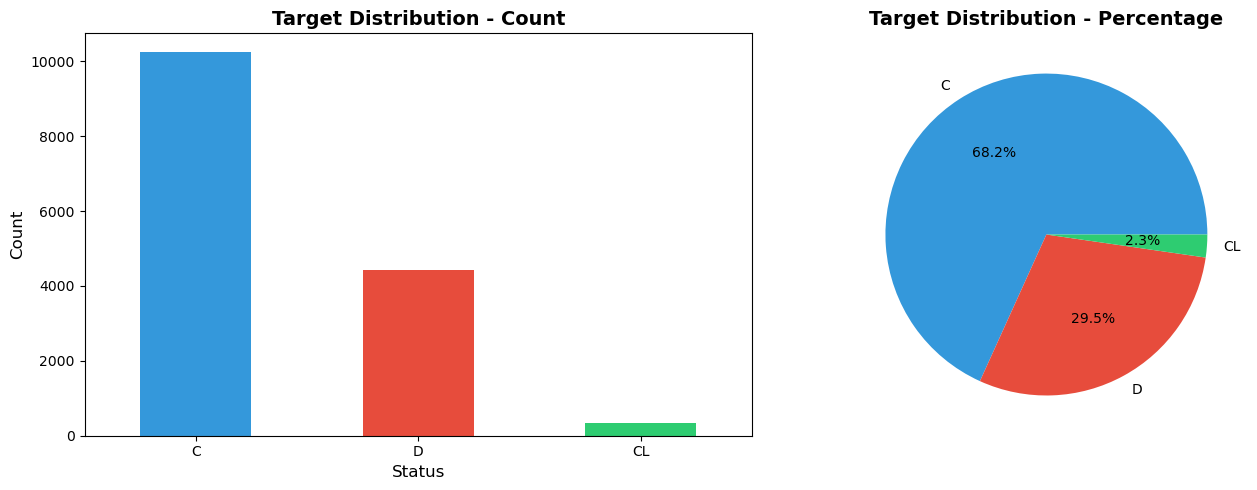

In [84]:
# Target distribution
print("\n" + "=" * 50)
print("TARGET DISTRIBUTION")
print("=" * 50)
print(train_df['Status'].value_counts())
print(f"\nPercentages:")
print(train_df['Status'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
train_df['Status'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Target Distribution - Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(rotation=0)

# Pie chart
train_df['Status'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                         colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Target Distribution - Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

<Axes: >

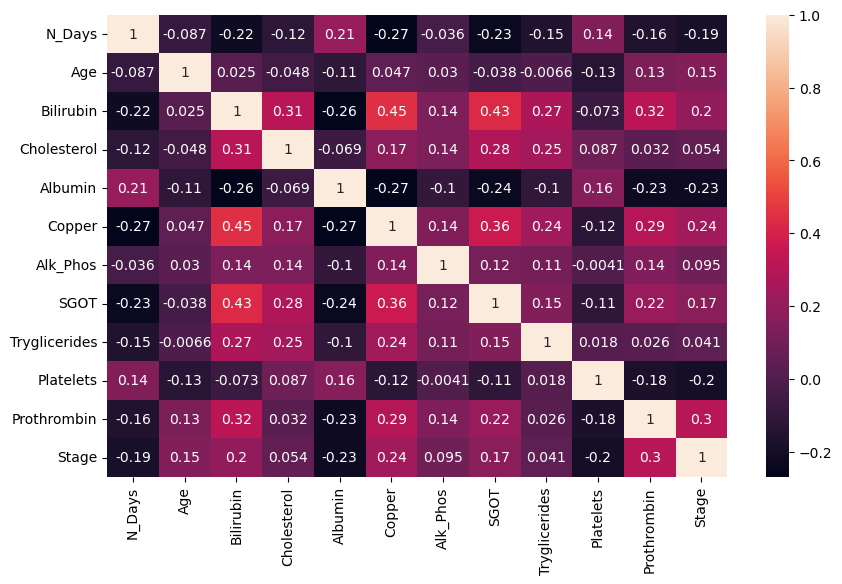

In [85]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')


plt.figure(figsize=(10,6))
sns.heatmap(train_df[numerical_cols].corr(), annot=True)

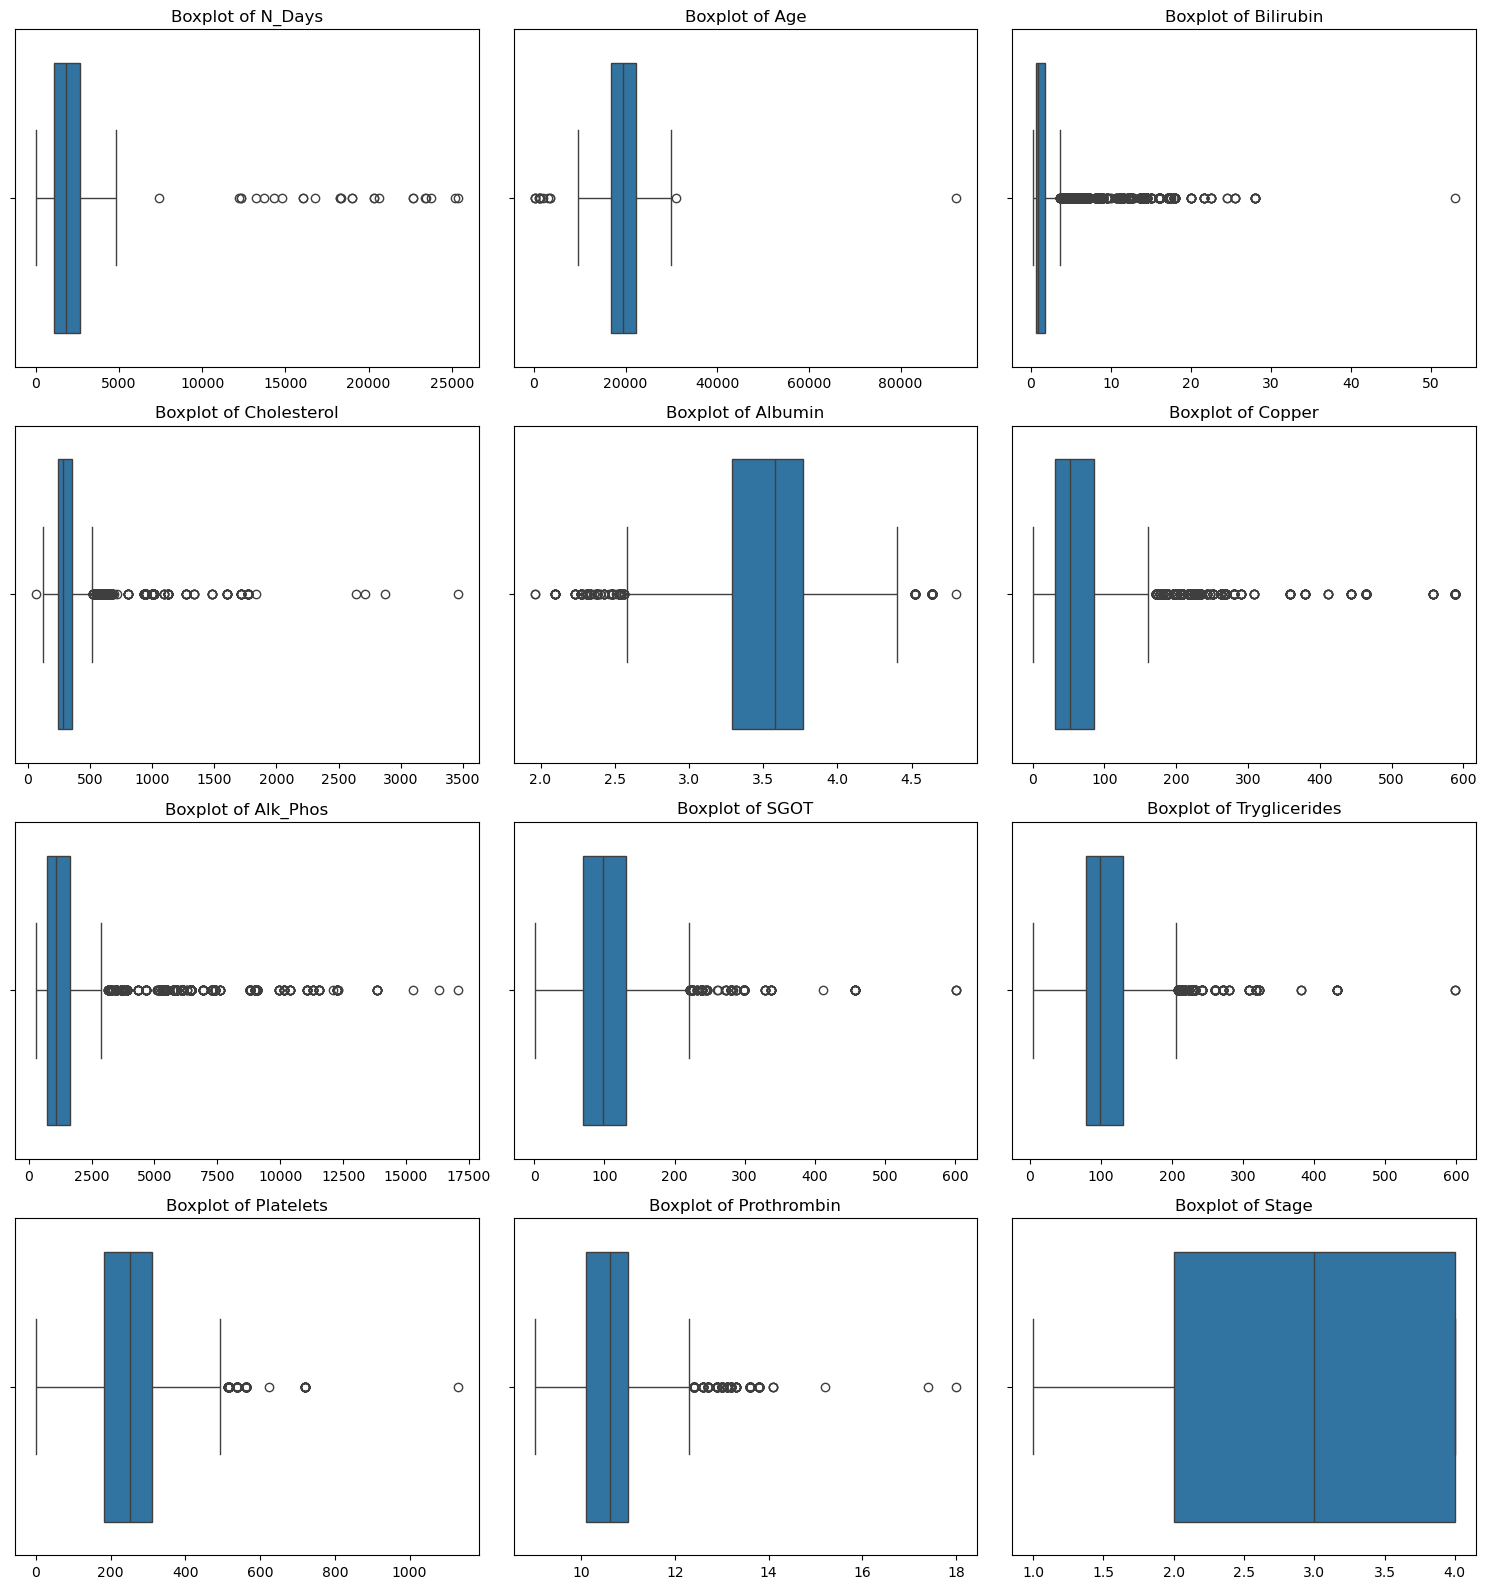

In [86]:
#boxplot to identify outliers for all numerical columns in subplots

numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()

# Remove 'id' column if present, as it's an identifier and not relevant for outlier analysis
if 'id' in numerical_cols:
    numerical_cols.remove('id')

n_cols = 3 # Number of columns for the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=train_df, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('') # Hide x-label to prevent clutter if rotated

# Hide any unused subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

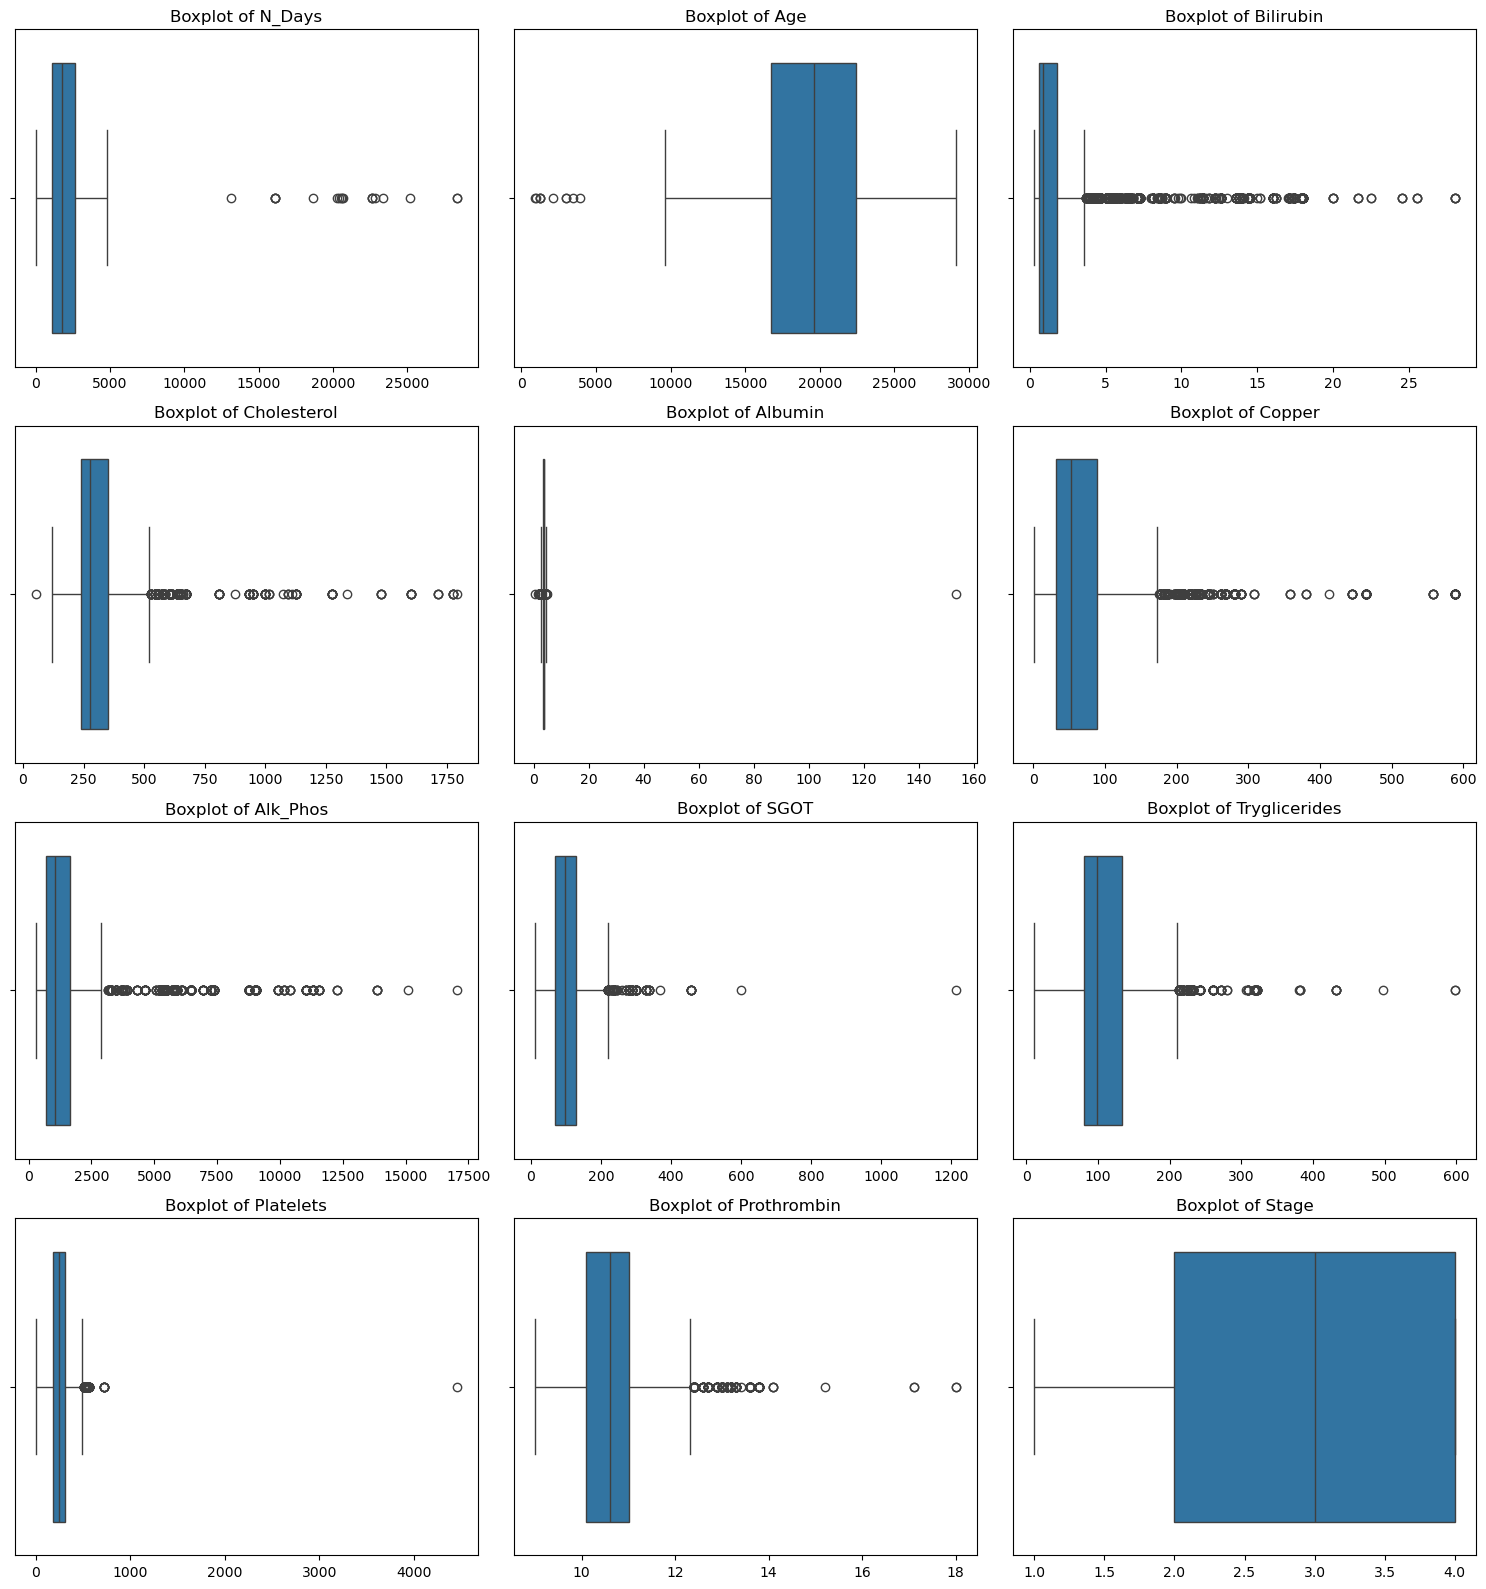

In [87]:
#boxplot to identify outliers for all numerical columns in subplots

numerical_cols = test_df.select_dtypes(include=np.number).columns.tolist()

# Remove 'id' column if present, as it's an identifier and not relevant for outlier analysis
if 'id' in numerical_cols:
    numerical_cols.remove('id')

n_cols = 3 # Number of columns for the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=test_df, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('') # Hide x-label to prevent clutter if rotated

# Hide any unused subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.3 Distribution of Numerical Features

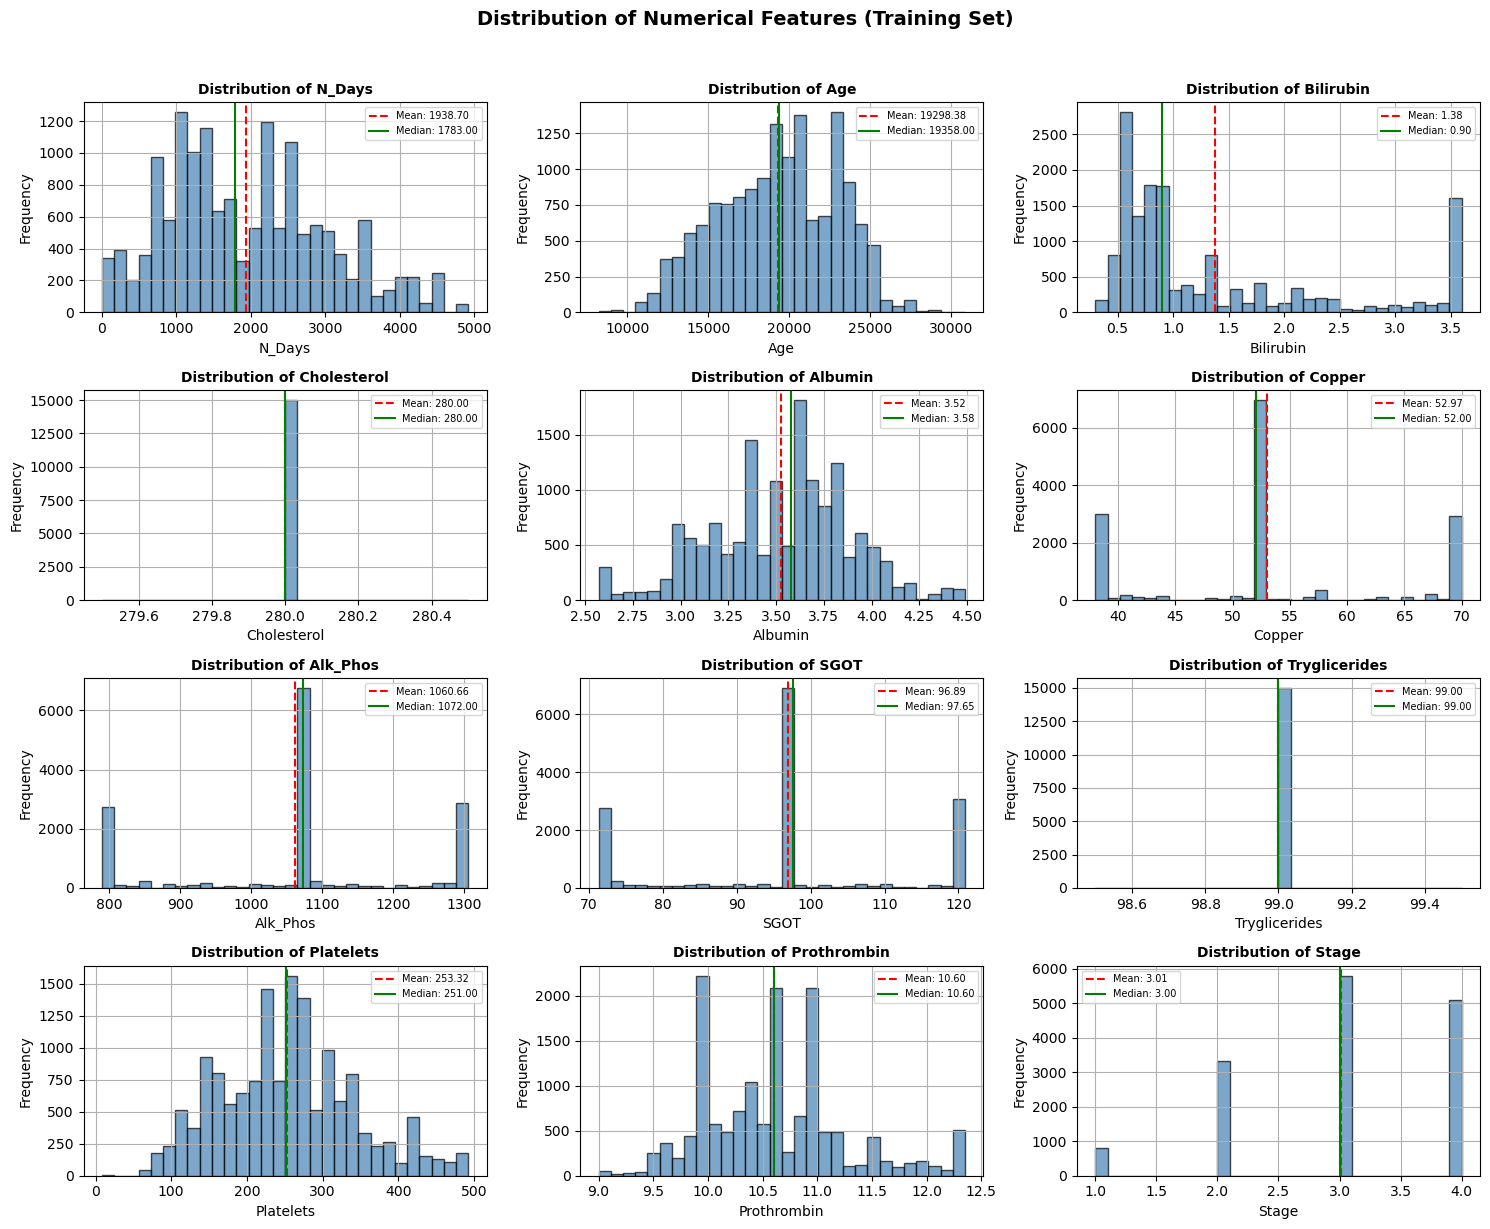

In [107]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')

n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    train_df[col].hist(ax=axes[i], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=10, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(train_df[col].mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {train_df[col].mean():.2f}')
    axes[i].axvline(train_df[col].median(), color='green', linestyle='-', linewidth=1.5, label=f'Median: {train_df[col].median():.2f}')
    axes[i].legend(fontsize=7)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Numerical Features (Training Set)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1.4 Feature Distribution by Target Class

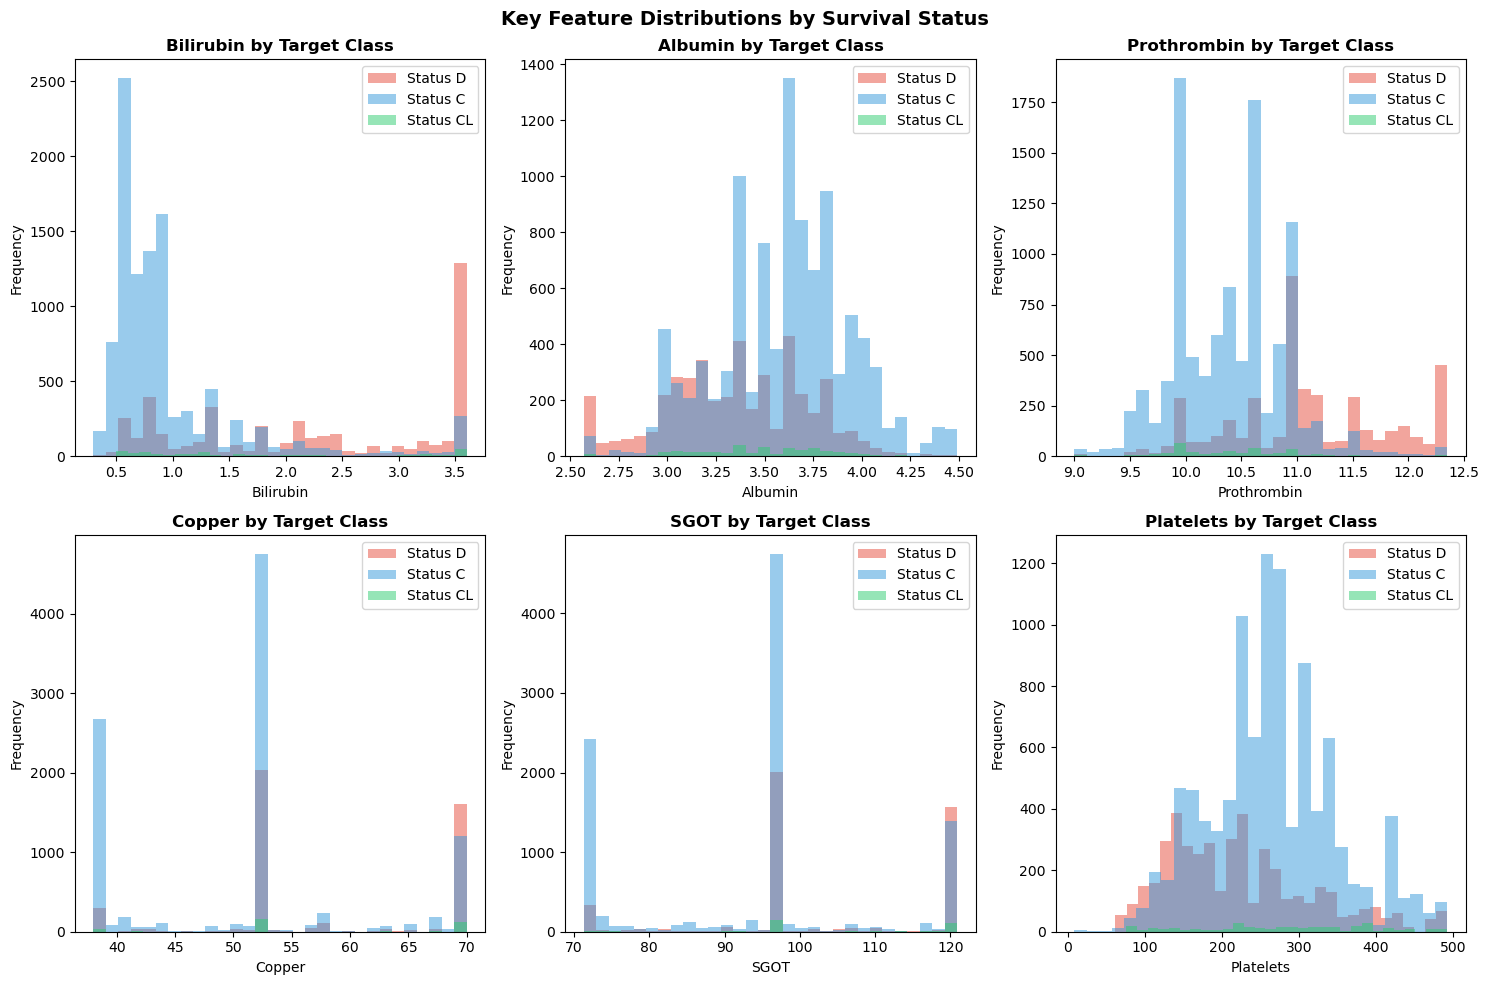

In [108]:
key_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Copper', 'SGOT', 'Platelets']
key_features = [f for f in key_features if f in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = {'C': '#3498db', 'CL': '#2ecc71', 'D': '#e74c3c'}

for i, col in enumerate(key_features):
    for status in train_df['Status'].unique():
        subset = train_df[train_df['Status'] == status][col].dropna()
        axes[i].hist(subset, bins=30, alpha=0.5, label=f'Status {status}', color=colors.get(status, 'gray'))
    axes[i].set_title(f'{col} by Target Class', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.suptitle('Key Feature Distributions by Survival Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.5 Categorical Feature Analysis

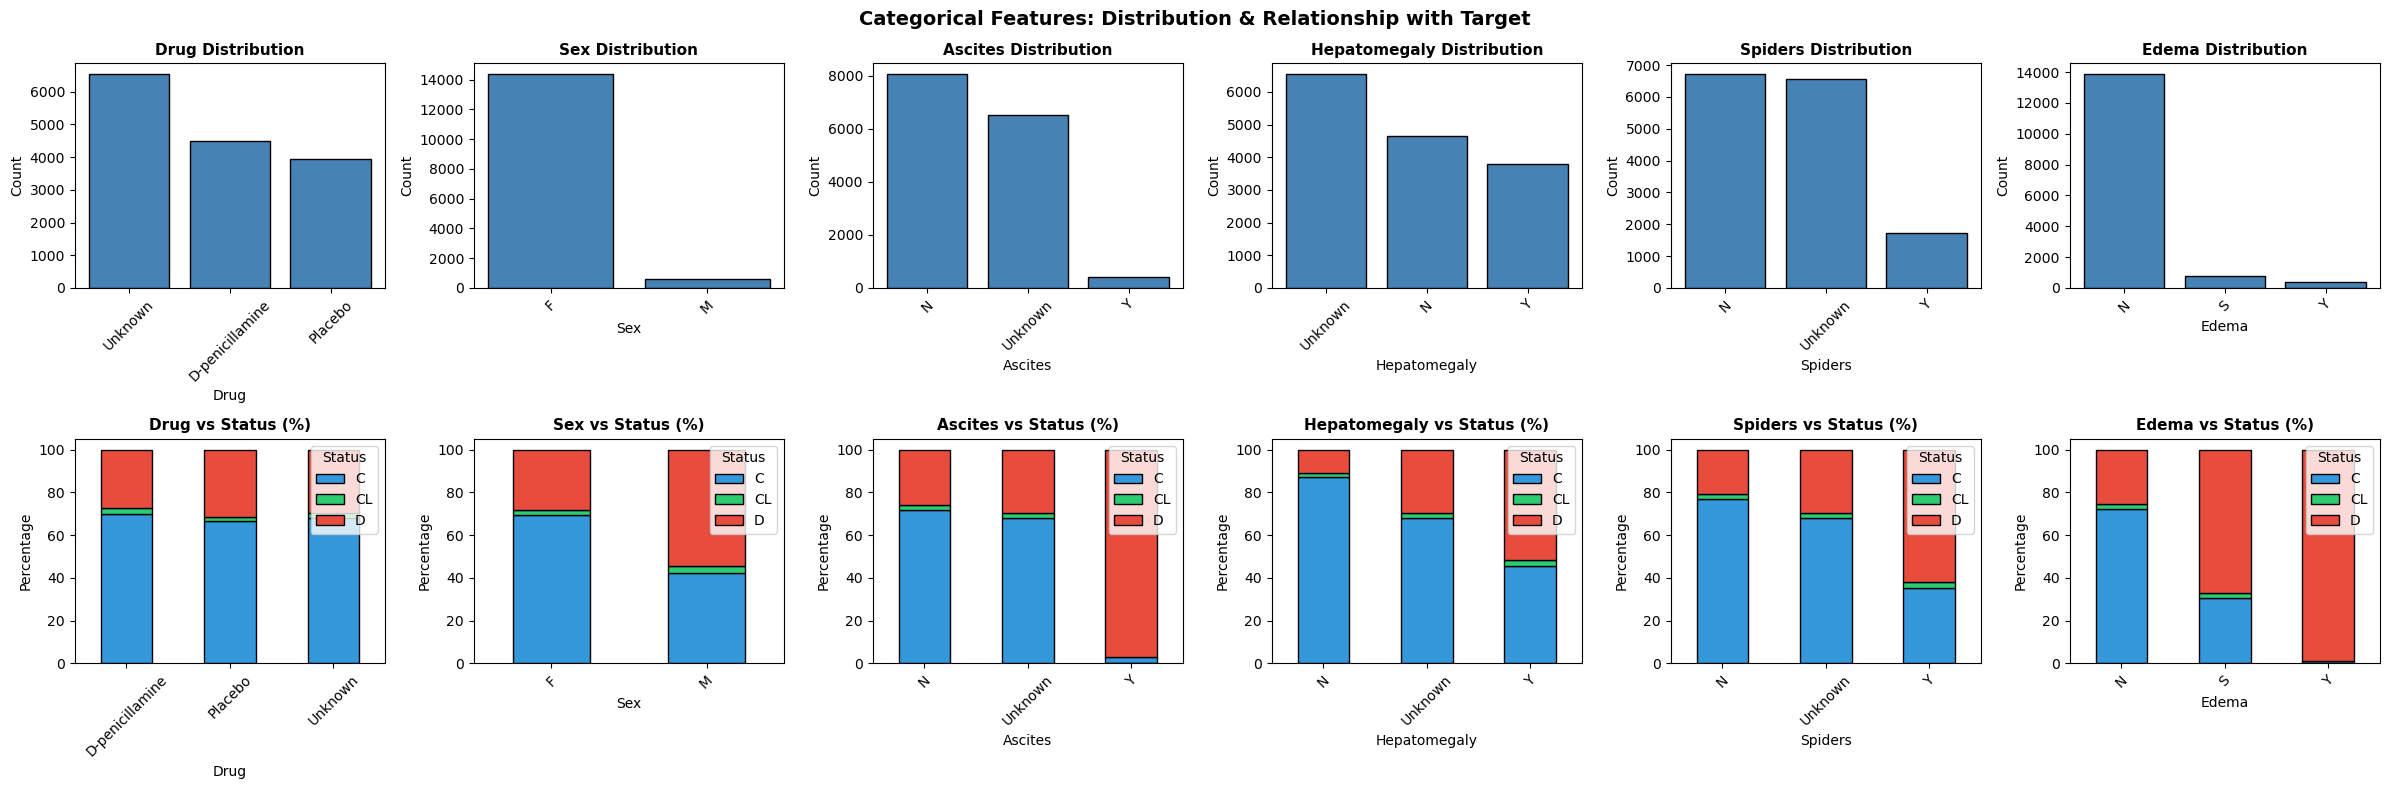

In [109]:
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
if 'Status' in categorical_cols:
    categorical_cols.remove('Status')

n_cats = len(categorical_cols)
fig, axes = plt.subplots(2, n_cats, figsize=(4*n_cats, 8))

for i, col in enumerate(categorical_cols):
    counts = train_df[col].value_counts()
    axes[0, i].bar(counts.index.astype(str), counts.values, color='steelblue', edgecolor='black')
    axes[0, i].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Count')
    axes[0, i].tick_params(axis='x', rotation=45)
    
    ct = pd.crosstab(train_df[col], train_df['Status'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[1, i], stacked=True, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
    axes[1, i].set_title(f'{col} vs Status (%)', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel('Percentage')
    axes[1, i].legend(title='Status', loc='upper right')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.suptitle('Categorical Features: Distribution & Relationship with Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.6 Pairplot of Key Features

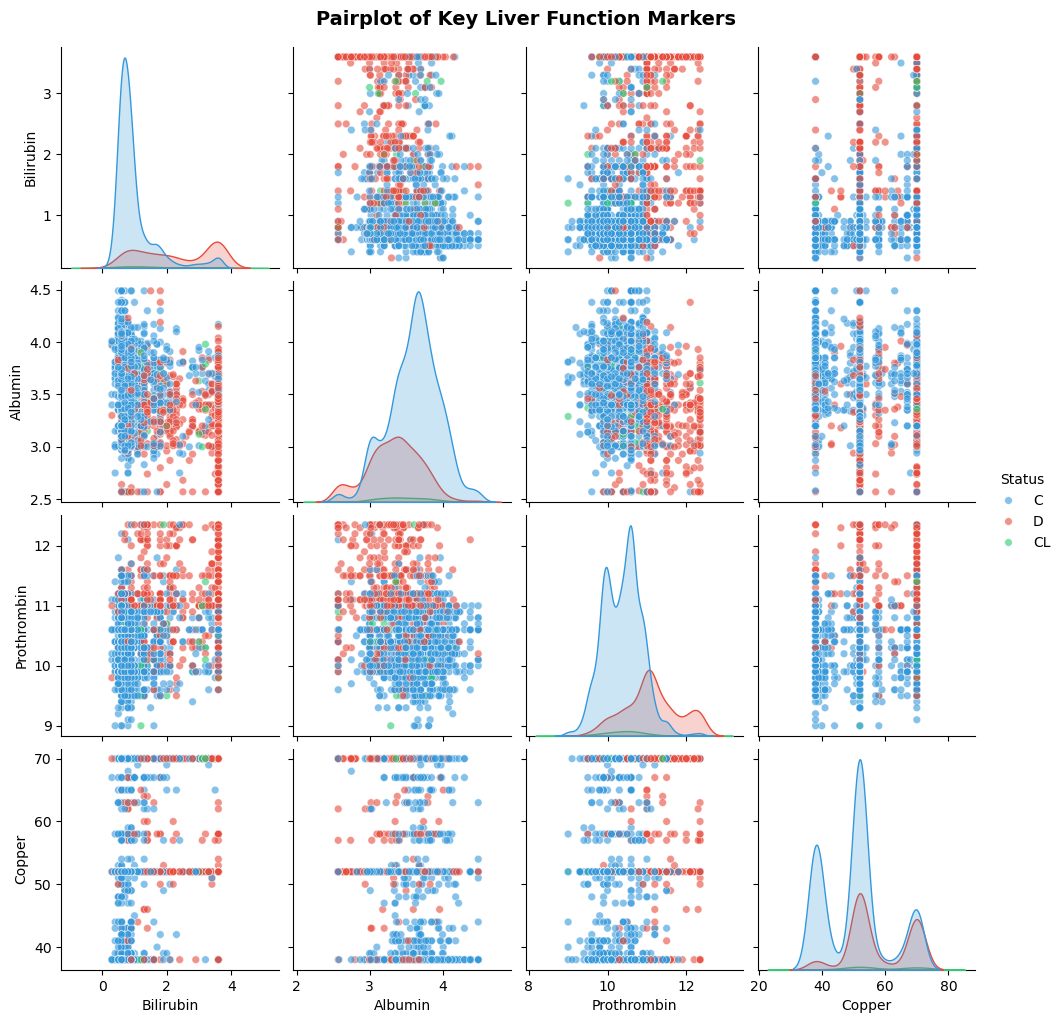

In [110]:
pairplot_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Copper', 'Status']
pairplot_features = [f for f in pairplot_features if f in train_df.columns]

sample_df = train_df[pairplot_features].dropna().sample(n=min(2000, len(train_df)), random_state=42)

sns.pairplot(sample_df, hue='Status', palette={'C': '#3498db', 'CL': '#2ecc71', 'D': '#e74c3c'}, 
             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
plt.suptitle('Pairplot of Key Liver Function Markers', fontsize=14, fontweight='bold', y=1.02)
plt.show()

### 1.7 Violin Plots - Feature Distribution by Status

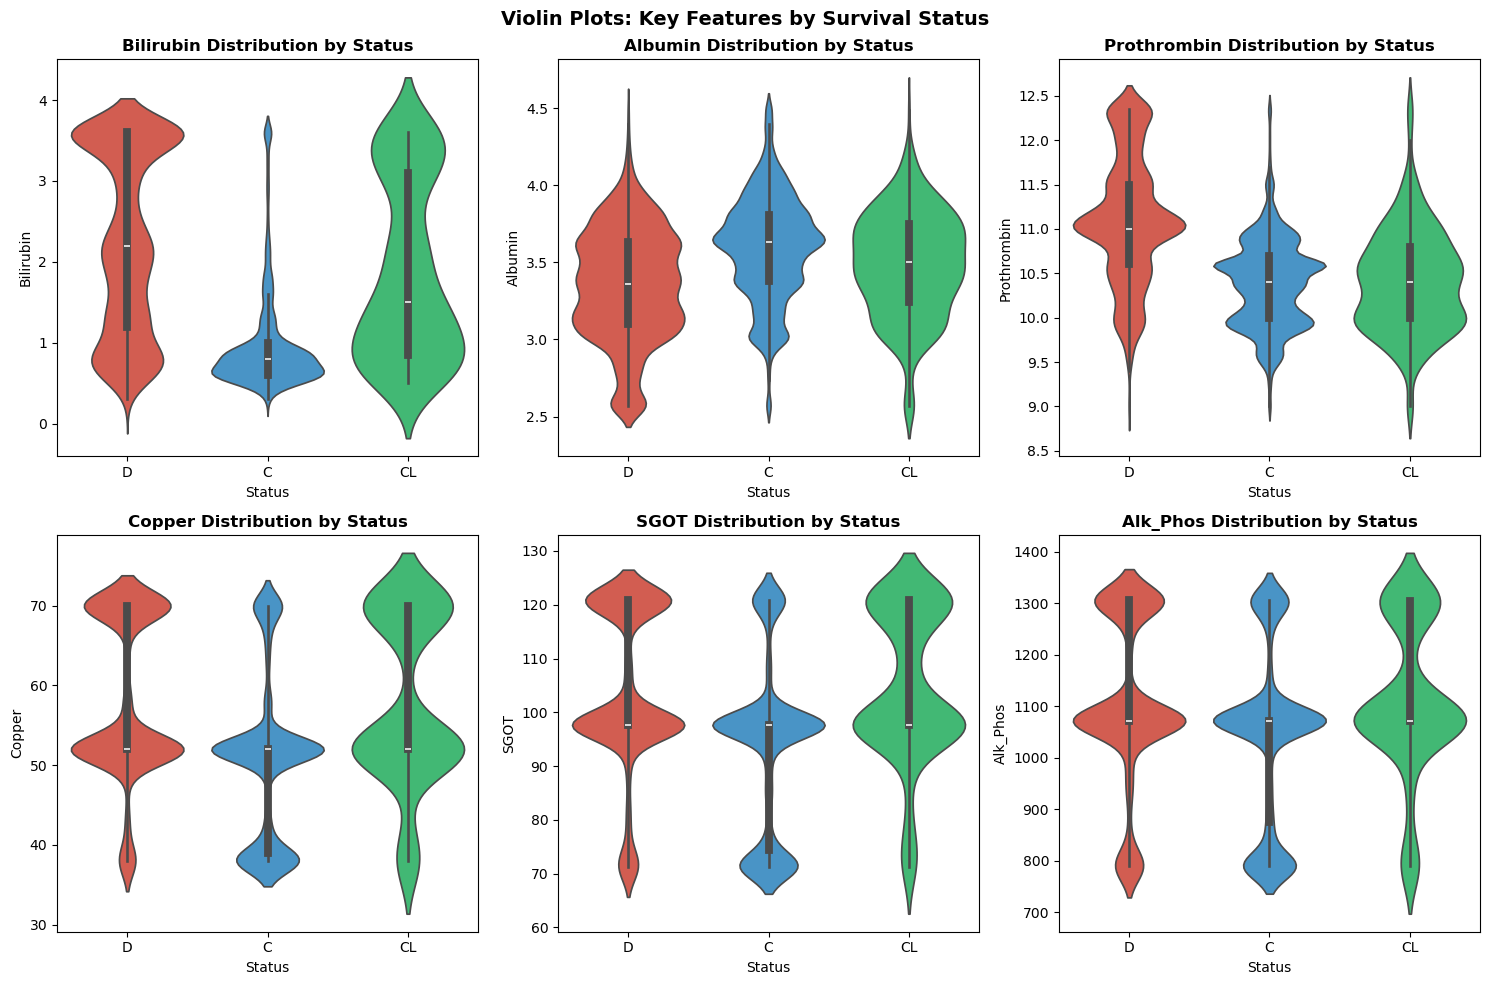

In [111]:
violin_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Copper', 'SGOT', 'Alk_Phos']
violin_features = [f for f in violin_features if f in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(violin_features):
    sns.violinplot(data=train_df, x='Status', y=col, ax=axes[i], 
                   palette={'C': '#3498db', 'CL': '#2ecc71', 'D': '#e74c3c'})
    axes[i].set_title(f'{col} Distribution by Status', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Status')
    axes[i].set_ylabel(col)

plt.suptitle('Violin Plots: Key Features by Survival Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 2. Data Cleaning & Preprocessing

**Steps performed:**
1. Handle missing values using median imputation for numerical features
2. Cap outliers using IQR method
3. Fix garbage values (e.g., '119.35' in Spiders column)
4. Impute categorical missing values with 'Unknown'

In [88]:
# Check if 'id' exists before trying to save it
if 'id' in test_df.columns:
    test_ids = test_df['id'].copy()
    train_df = train_df.drop('id', axis=1)
    test_df = test_df.drop('id', axis=1)
else:
    print("'id' column already dropped. Using sample_submission IDs for final output.")

In [89]:
from sklearn.impute import SimpleImputer

# Initialize MedianImputer
median_imputer = SimpleImputer(strategy='median')

# Identify numerical columns (excluding 'id' as it was dropped)
numerical_cols_train = train_df.select_dtypes(include=['number']).columns.tolist()
numerical_cols_test = test_df.select_dtypes(include=['number']).columns.tolist()

# Apply MedianImputer to train_df
train_df[numerical_cols_train] = median_imputer.fit_transform(train_df[numerical_cols_train])

# Apply MedianImputer to test_df
test_df[numerical_cols_test] = median_imputer.fit_transform(test_df[numerical_cols_test])

In [90]:
print('Missing values in train_df after MedianImputer for numerical columns:')
print(train_df.select_dtypes(include='number').isnull().sum())

Missing values in train_df after MedianImputer for numerical columns:
N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [91]:
print('\nMissing values in test_df after MedianImputer for numerical columns:')
print(test_df.select_dtypes(include='number').isnull().sum())


Missing values in test_df after MedianImputer for numerical columns:
N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [92]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values outside the bounds
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Apply outlier capping to numerical columns in train_df
for col in numerical_cols_train:
    train_df = cap_outliers_iqr(train_df, col)

# Apply outlier capping to numerical columns in test_df
for col in numerical_cols_test:
    test_df = cap_outliers_iqr(test_df, col)


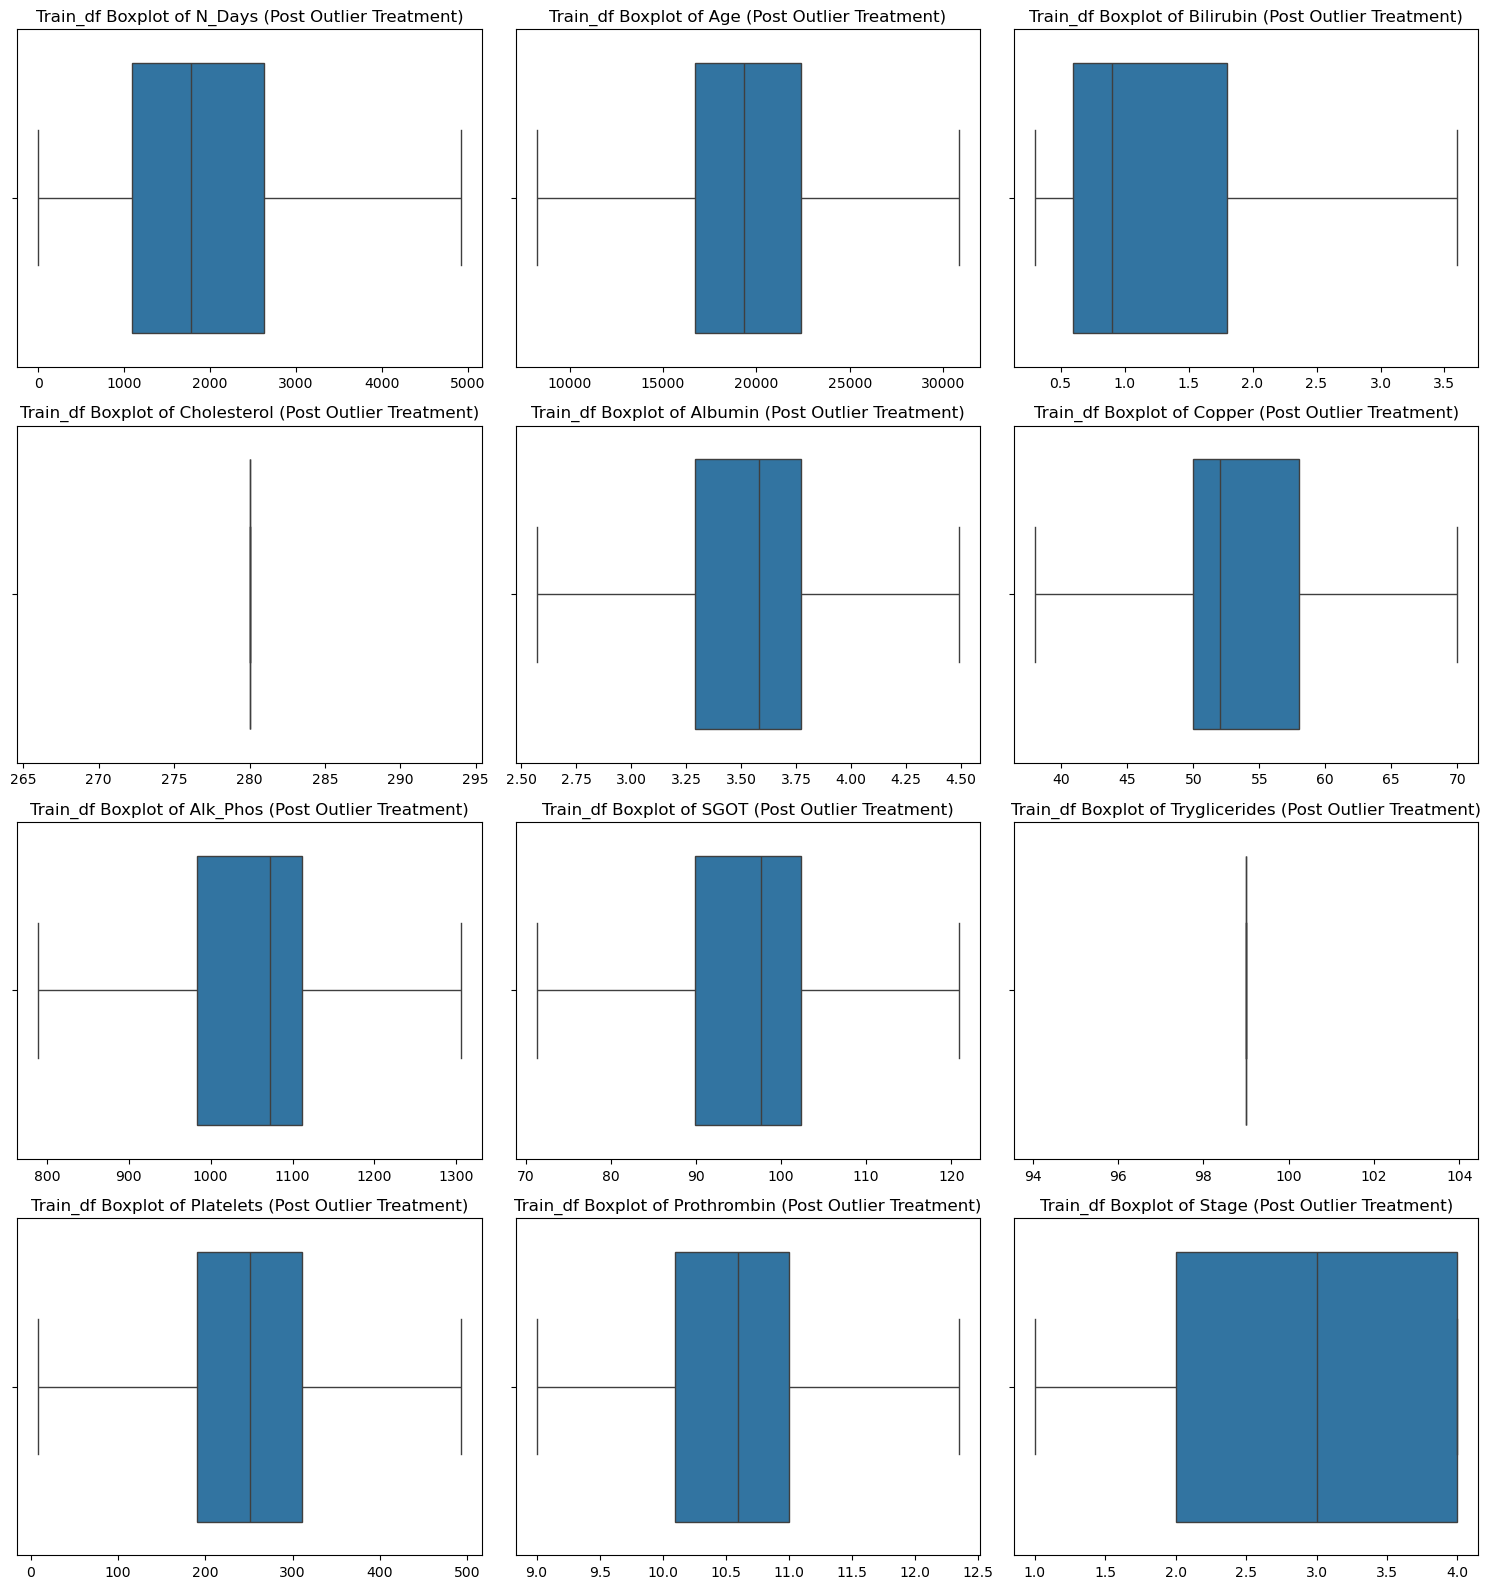

Boxplots for train_df (post outlier treatment) displayed.


In [93]:
n_cols = 3 # Number of columns for the subplot grid
n_rows_train = (len(numerical_cols_train) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows_train, n_cols, figsize=(15, n_rows_train * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols_train):
    sns.boxplot(data=train_df, x=col, ax=axes[i])
    axes[i].set_title(f'Train_df Boxplot of {col} (Post Outlier Treatment)')
    axes[i].set_xlabel('') # Hide x-label to prevent clutter if rotated

# Hide any unused subplots
for j in range(len(numerical_cols_train), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Boxplots for train_df (post outlier treatment) displayed.")

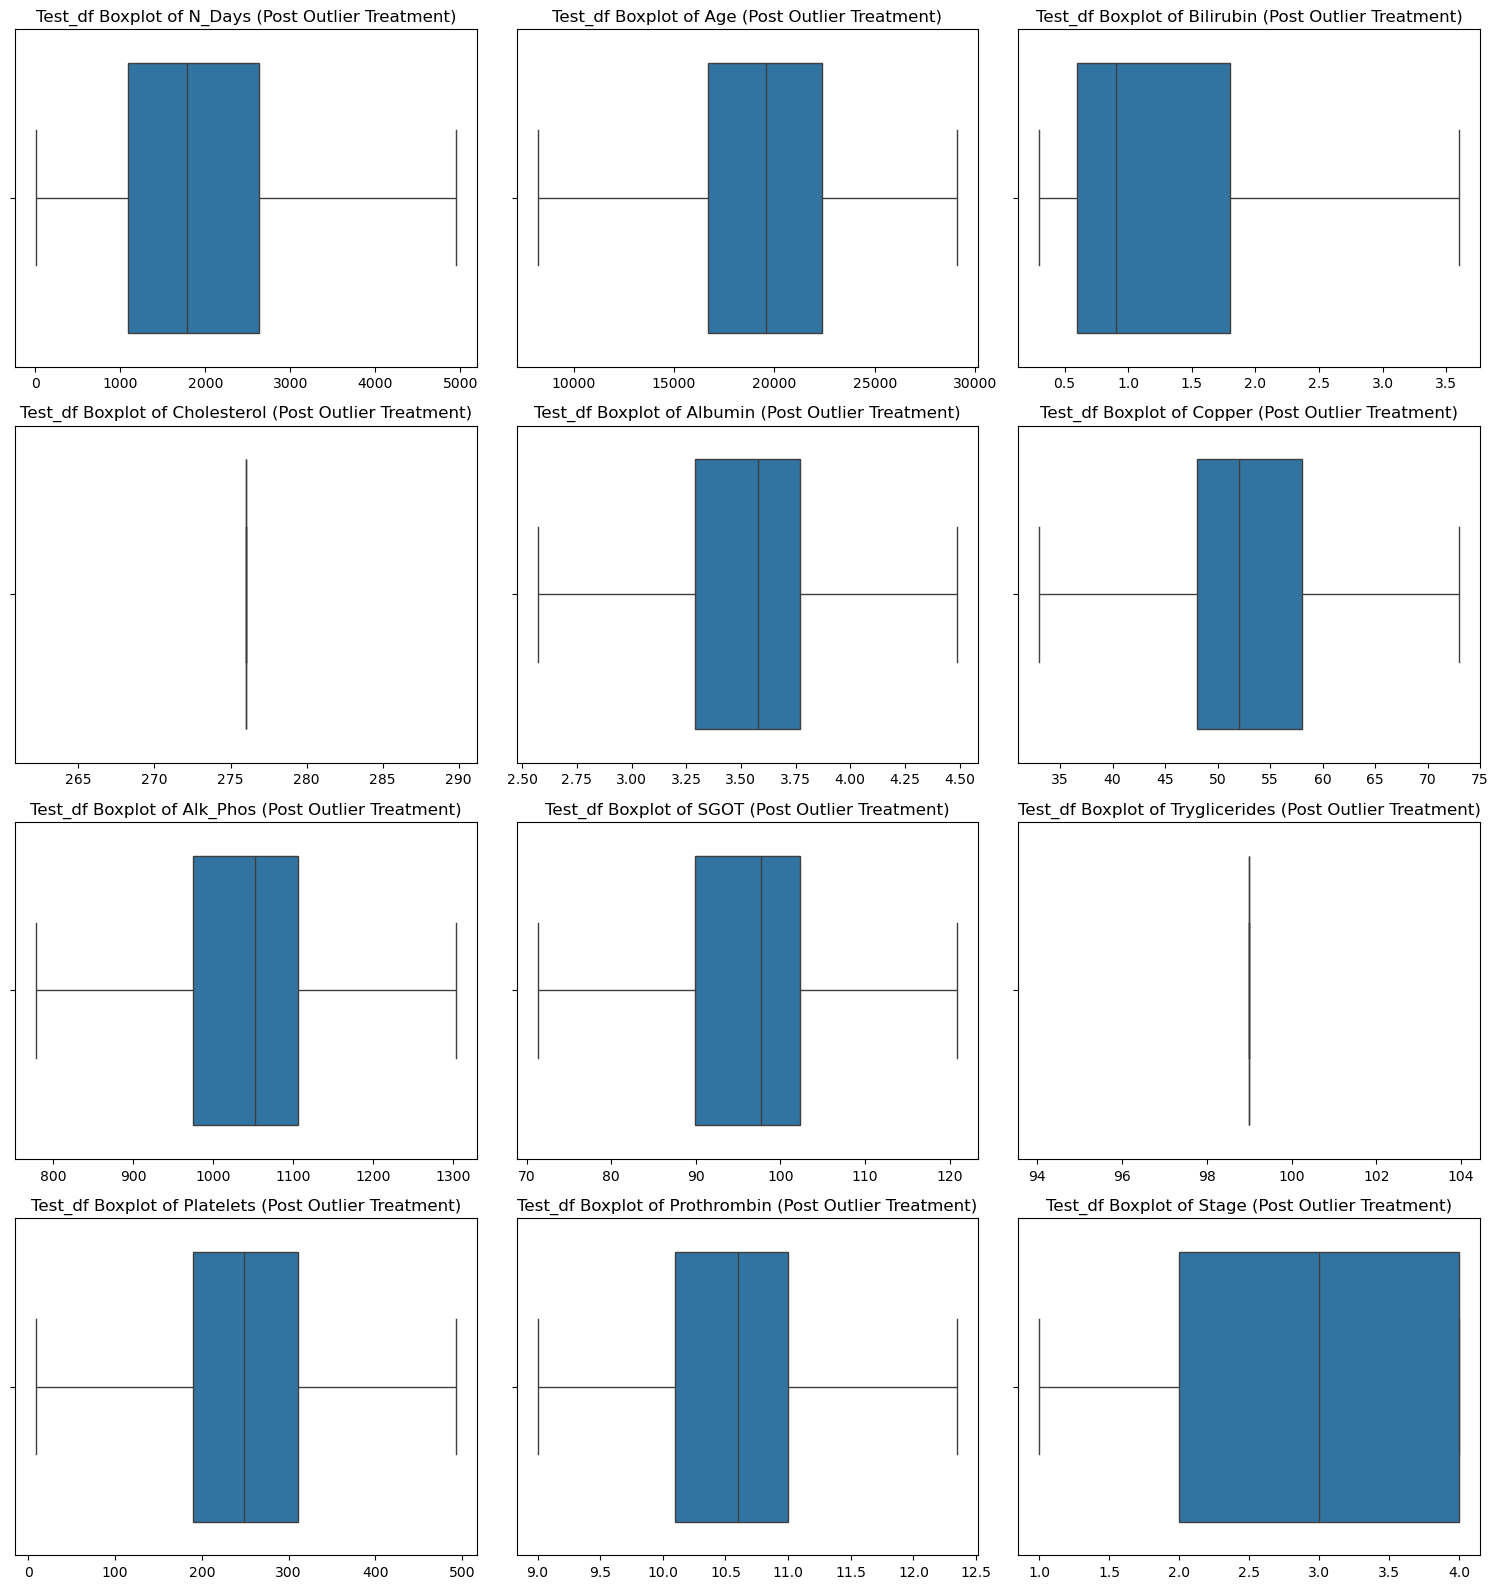

Boxplots for test_df (post outlier treatment) displayed.


In [94]:
n_cols = 3 # Number of columns for the subplot grid
n_rows_test = (len(numerical_cols_test) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows_test, n_cols, figsize=(15, n_rows_test * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols_test):
    sns.boxplot(data=test_df, x=col, ax=axes[i])
    axes[i].set_title(f'Test_df Boxplot of {col} (Post Outlier Treatment)')
    axes[i].set_xlabel('') # Hide x-label to prevent clutter if rotated

# Hide any unused subplots
for j in range(len(numerical_cols_test), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Boxplots for test_df (post outlier treatment) displayed.")

In [95]:
# Identify the garbage value in 'Spiders' column
garbage_value = '119.35'

# Replace the garbage value with NaN
train_df['Spiders'] = train_df['Spiders'].replace(garbage_value, np.nan)

print(train_df["Spiders"].value_counts())

Spiders
N    6717
Y    1731
Name: count, dtype: int64


In [96]:
# Identify categorical columns with missing values
categorical_cols_with_na_train = train_df.select_dtypes(include='object').columns[train_df.select_dtypes(include='object').isnull().any()].tolist()
categorical_cols_with_na_test = test_df.select_dtypes(include='object').columns[test_df.select_dtypes(include='object').isnull().any()].tolist()

print("Categorical columns in train_df with missing values:", categorical_cols_with_na_train)
print("Categorical columns in test_df with missing values:", categorical_cols_with_na_test)

# Impute missing categorical values with 'Unknown'
for col in categorical_cols_with_na_train:
    train_df[col] = train_df[col].fillna('Unknown')

for col in categorical_cols_with_na_test:
    test_df[col] = test_df[col].fillna('Unknown')

print('\nMissing values in train_df after categorical imputation:')
print(train_df.isnull().sum())

print('\nMissing values in test_df after categorical imputation:')
print(test_df.isnull().sum())

Categorical columns in train_df with missing values: ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
Categorical columns in test_df with missing values: ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']

Missing values in train_df after categorical imputation:
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

Missing values in test_df after categorical imputation:
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrom

---

## 3. Model Choice & Tuning

### 3.1 Feature Engineering

Creating domain-specific features to capture medical relationships:
- **Liver function ratios:** Bilirubin/Albumin, SGOT/Alk_Phos
- **Disease markers:** Copper/Albumin (Wilson's disease indicator)
- **Metabolic features:** Cholesterol/Triglycerides ratio
- **Coagulation features:** Platelets/Prothrombin ratio
- **Log transformations:** For skewed distributions
- **Polynomial features:** Age squared, N_Days squared

In [97]:
# Reload pristine copies to avoid leakage from earlier in-notebook preprocessing
raw_train = pd.read_csv(train_path)
raw_test = pd.read_csv(test_path)

# Fix the known garbage value in 'Spiders' and coerce the column back to numeric
for df in (raw_train, raw_test):
    if 'Spiders' in df.columns:
        df['Spiders'] = pd.to_numeric(df['Spiders'].replace('119.35', np.nan), errors='coerce')

feature_cols = [col for col in raw_train.columns if col not in ['id', 'Status']]
X_full = raw_train[feature_cols].copy()
X_test_full = raw_test.reindex(columns=feature_cols).copy()
y_full = raw_train['Status'].copy()

# ============================================
# FEATURE ENGINEERING - Create new features
# ============================================
def add_features(df):
    """Add engineered features to improve model performance."""
    df = df.copy()
    
    # Bilirubin-related features (important for liver function)
    if 'Bilirubin' in df.columns and 'Albumin' in df.columns:
        df['Bilirubin_Albumin_ratio'] = df['Bilirubin'] / (df['Albumin'] + 0.001)
    
    # Liver enzyme ratios
    if 'SGOT' in df.columns and 'Alk_Phos' in df.columns:
        df['SGOT_Alk_Phos_ratio'] = df['SGOT'] / (df['Alk_Phos'] + 0.001)
    
    # Copper-related (Wilson's disease marker)
    if 'Copper' in df.columns and 'Albumin' in df.columns:
        df['Copper_Albumin_ratio'] = df['Copper'] / (df['Albumin'] + 0.001)
    
    # Cholesterol-related features
    if 'Cholesterol' in df.columns and 'Tryglicerides' in df.columns:
        df['Chol_Tryg_ratio'] = df['Cholesterol'] / (df['Tryglicerides'] + 0.001)
    
    # Platelet-related features
    if 'Platelets' in df.columns and 'Prothrombin' in df.columns:
        df['Platelets_Prothrombin_ratio'] = df['Platelets'] / (df['Prothrombin'] + 0.001)
    
    # Age in years
    if 'Age' in df.columns:
        df['Age_years'] = df['Age'] / 365.25
        df['Age_squared'] = df['Age_years'] ** 2
    
    # Log transformations for skewed features
    for col in ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides']:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))
    
    # N_Days features
    if 'N_Days' in df.columns:
        df['N_Days_log'] = np.log1p(df['N_Days'].clip(lower=0))
        df['N_Days_squared'] = df['N_Days'] ** 2
    
    return df

# Apply feature engineering
X_full = add_features(X_full)
X_test_full = add_features(X_test_full)

categorical_features = sorted(list(set(
    X_full.select_dtypes(include='object').columns.tolist() +
    X_test_full.select_dtypes(include='object').columns.tolist()
)))
numeric_features = [col for col in X_full.columns if col not in categorical_features]

for df in (X_full, X_test_full):
    if categorical_features:
        df[categorical_features] = df[categorical_features].fillna('Unknown')

print(f"Captured {len(numeric_features)} numeric features and {len(categorical_features)} categorical features.")
print(f"New features added: {[c for c in X_full.columns if c not in feature_cols]}")

Captured 28 numeric features and 5 categorical features.
New features added: ['Bilirubin_Albumin_ratio', 'SGOT_Alk_Phos_ratio', 'Copper_Albumin_ratio', 'Chol_Tryg_ratio', 'Platelets_Prothrombin_ratio', 'Age_years', 'Age_squared', 'Bilirubin_log', 'Cholesterol_log', 'Copper_log', 'Alk_Phos_log', 'SGOT_log', 'Tryglicerides_log', 'N_Days_log', 'N_Days_squared']


### 3.2 Model Selection & Hyperparameter Tuning

**Model:** XGBoost Classifier (GPU-accelerated)

**Why XGBoost?**
- Handles mixed feature types (numerical + categorical)
- Built-in regularization to prevent overfitting
- Excellent performance on tabular data
- GPU support for faster training

**Hyperparameters (Optuna-tuned):**
- `n_estimators`: 996
- `max_depth`: 5 (shallow trees to prevent overfitting)
- `learning_rate`: 0.026 (low for better generalization)
- `min_child_weight`: 20 (high for regularization)
- `subsample`: 0.84, `colsample_bytree`: 0.44 (feature/sample bagging)
- `reg_alpha`: 1.24 (L1 regularization)

**Cross-Validation Strategy:**
- 10-Fold Stratified K-Fold × 5 Random Seeds = 50 models averaged
- Multi-seed averaging reduces variance and improves generalization

In [98]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import numpy as np

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_full)
num_classes = len(label_encoder.classes_)

BEST_XGB_PARAMS = {
    'n_estimators': 996,
    'max_depth': 5,
    'learning_rate': 0.026125569937535616,
    'min_child_weight': 20,
    'subsample': 0.8372216638739537,
    'colsample_bytree': 0.43928221172525717,
    'colsample_bylevel': 0.43979814481244345,
    'reg_alpha': 1.2410723526138414,
    'reg_lambda': 1.937232568171868e-06,
    'gamma': 0.00024182974280729868,
    'device': 'cuda',
    'tree_method': 'hist',
    'objective': 'multi:softprob',
    'num_class': 3,
    'verbosity': 0,
}

def build_optimized_xgb_pipe(random_state=42):
    params = BEST_XGB_PARAMS.copy()
    params['random_state'] = random_state
    
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features)
    ])
    
    return Pipeline([
        ('prep', preprocessor),
        ('model', XGBClassifier(**params))
    ])

N_FOLDS = 10
SEEDS = [42, 2024, 1337, 7, 123]

oof_xgb_all = np.zeros((len(X_full), num_classes))
test_xgb_all = np.zeros((len(X_test_full), num_classes))

for seed_idx, seed in enumerate(SEEDS):
    print(f"Seed {seed}")
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    oof_xgb = np.zeros((len(X_full), num_classes))
    test_xgb = np.zeros((len(X_test_full), num_classes))
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_full, y_encoded), start=1):
        X_train_fold = X_full.iloc[train_idx]
        X_val_fold = X_full.iloc[val_idx]
        y_train_fold = y_encoded[train_idx]
        y_val_fold = y_encoded[val_idx]
        
        pipe_xgb = build_optimized_xgb_pipe(random_state=seed + fold_idx)
        pipe_xgb.fit(X_train_fold, y_train_fold)
        oof_xgb[val_idx] = pipe_xgb.predict_proba(X_val_fold)
        test_xgb += pipe_xgb.predict_proba(X_test_full) / N_FOLDS
        
    oof_xgb_all += oof_xgb / len(SEEDS)
    test_xgb_all += test_xgb / len(SEEDS)
    
    print(f"Seed {seed} LogLoss: {log_loss(y_encoded, oof_xgb):.5f}")

print(f"Final OOF LogLoss: {log_loss(y_encoded, oof_xgb_all):.5f}")

Seed 42
Seed 42 LogLoss: 0.35344
Seed 2024
Seed 42 LogLoss: 0.35344
Seed 2024
Seed 2024 LogLoss: 0.35370
Seed 1337
Seed 2024 LogLoss: 0.35370
Seed 1337
Seed 1337 LogLoss: 0.35411
Seed 7
Seed 1337 LogLoss: 0.35411
Seed 7
Seed 7 LogLoss: 0.35409
Seed 123
Seed 7 LogLoss: 0.35409
Seed 123
Seed 123 LogLoss: 0.35375
Final OOF LogLoss: 0.35214
Seed 123 LogLoss: 0.35375
Final OOF LogLoss: 0.35214


### 3.3 Random Forest Model Training

Training Random Forest classifier with the same cross-validation strategy for fair comparison.

In [115]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Parameters
RF_PARAMS = {
    'n_estimators': 500,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'n_jobs': -1,
    'verbose': 0
}

def build_rf_pipe(random_state=42):
    params = RF_PARAMS.copy()
    params['random_state'] = random_state
    
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features)
    ])
    
    return Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestClassifier(**params))
    ])

# Train Random Forest with same CV strategy
oof_rf_all = np.zeros((len(X_full), num_classes))
test_rf_all = np.zeros((len(X_test_full), num_classes))

print("=" * 60)
print("RANDOM FOREST TRAINING")
print("=" * 60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\nSeed {seed}")
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    oof_rf = np.zeros((len(X_full), num_classes))
    test_rf = np.zeros((len(X_test_full), num_classes))
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_full, y_encoded), start=1):
        X_train_fold = X_full.iloc[train_idx]
        X_val_fold = X_full.iloc[val_idx]
        y_train_fold = y_encoded[train_idx]
        y_val_fold = y_encoded[val_idx]
        
        pipe_rf = build_rf_pipe(random_state=seed + fold_idx)
        pipe_rf.fit(X_train_fold, y_train_fold)
        oof_rf[val_idx] = pipe_rf.predict_proba(X_val_fold)
        test_rf += pipe_rf.predict_proba(X_test_full) / N_FOLDS
        
    oof_rf_all += oof_rf / len(SEEDS)
    test_rf_all += test_rf / len(SEEDS)
    
    print(f"  Seed {seed} LogLoss: {log_loss(y_encoded, oof_rf):.5f}")

rf_logloss = log_loss(y_encoded, oof_rf_all)
print(f"\n{'=' * 60}")
print(f"Random Forest Final OOF LogLoss: {rf_logloss:.5f}")
print(f"{'=' * 60}")

RANDOM FOREST TRAINING

Seed 42
  Seed 42 LogLoss: 0.41504

Seed 2024
  Seed 42 LogLoss: 0.41504

Seed 2024
  Seed 2024 LogLoss: 0.41605

Seed 1337
  Seed 2024 LogLoss: 0.41605

Seed 1337
  Seed 1337 LogLoss: 0.41557

Seed 7
  Seed 1337 LogLoss: 0.41557

Seed 7
  Seed 7 LogLoss: 0.41445

Seed 123
  Seed 7 LogLoss: 0.41445

Seed 123
  Seed 123 LogLoss: 0.41481

Random Forest Final OOF LogLoss: 0.41403
  Seed 123 LogLoss: 0.41481

Random Forest Final OOF LogLoss: 0.41403


### 3.4 LightGBM Model Training

Training LightGBM classifier with GPU acceleration for comparison.

In [117]:
from lightgbm import LGBMClassifier

# LightGBM Parameters (CPU version)
LGBM_PARAMS = {
    'n_estimators': 800,
    'max_depth': 7,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'objective': 'multiclass',
    'num_class': 3,
    'verbose': -1,
    'n_jobs': -1
}

def build_lgbm_pipe(random_state=42):
    params = LGBM_PARAMS.copy()
    params['random_state'] = random_state
    
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features)
    ])
    
    return Pipeline([
        ('prep', preprocessor),
        ('model', LGBMClassifier(**params))
    ])

# Train LightGBM with same CV strategy
oof_lgbm_all = np.zeros((len(X_full), num_classes))
test_lgbm_all = np.zeros((len(X_test_full), num_classes))

print("=" * 60)
print("LIGHTGBM TRAINING")
print("=" * 60)

for seed_idx, seed in enumerate(SEEDS):
    print(f"\nSeed {seed}")
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    
    oof_lgbm = np.zeros((len(X_full), num_classes))
    test_lgbm = np.zeros((len(X_test_full), num_classes))
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_full, y_encoded), start=1):
        X_train_fold = X_full.iloc[train_idx]
        X_val_fold = X_full.iloc[val_idx]
        y_train_fold = y_encoded[train_idx]
        y_val_fold = y_encoded[val_idx]
        
        pipe_lgbm = build_lgbm_pipe(random_state=seed + fold_idx)
        pipe_lgbm.fit(X_train_fold, y_train_fold)
        oof_lgbm[val_idx] = pipe_lgbm.predict_proba(X_val_fold)
        test_lgbm += pipe_lgbm.predict_proba(X_test_full) / N_FOLDS
        
    oof_lgbm_all += oof_lgbm / len(SEEDS)
    test_lgbm_all += test_lgbm / len(SEEDS)
    
    print(f"  Seed {seed} LogLoss: {log_loss(y_encoded, oof_lgbm):.5f}")

lgbm_logloss = log_loss(y_encoded, oof_lgbm_all)
print(f"\n{'=' * 60}")
print(f"LightGBM Final OOF LogLoss: {lgbm_logloss:.5f}")
print(f"{'=' * 60}")

LIGHTGBM TRAINING

Seed 42
  Seed 42 LogLoss: 0.38419

Seed 2024
  Seed 2024 LogLoss: 0.38420

Seed 1337
  Seed 1337 LogLoss: 0.38434

Seed 7
  Seed 7 LogLoss: 0.38424

Seed 123
  Seed 123 LogLoss: 0.38385

LightGBM Final OOF LogLoss: 0.37511


### 3.5 Model Comparison

Comparing the performance of all three models to select the best one for final submission.

MODEL COMPARISON RESULTS

Model                OOF LogLoss     Rank      
---------------------------------------------
XGBoost              0.35214         1         
LightGBM             0.37511         2         
Random Forest        0.41403         3         
---------------------------------------------

🏆 Best Model: XGBoost with LogLoss = 0.35214


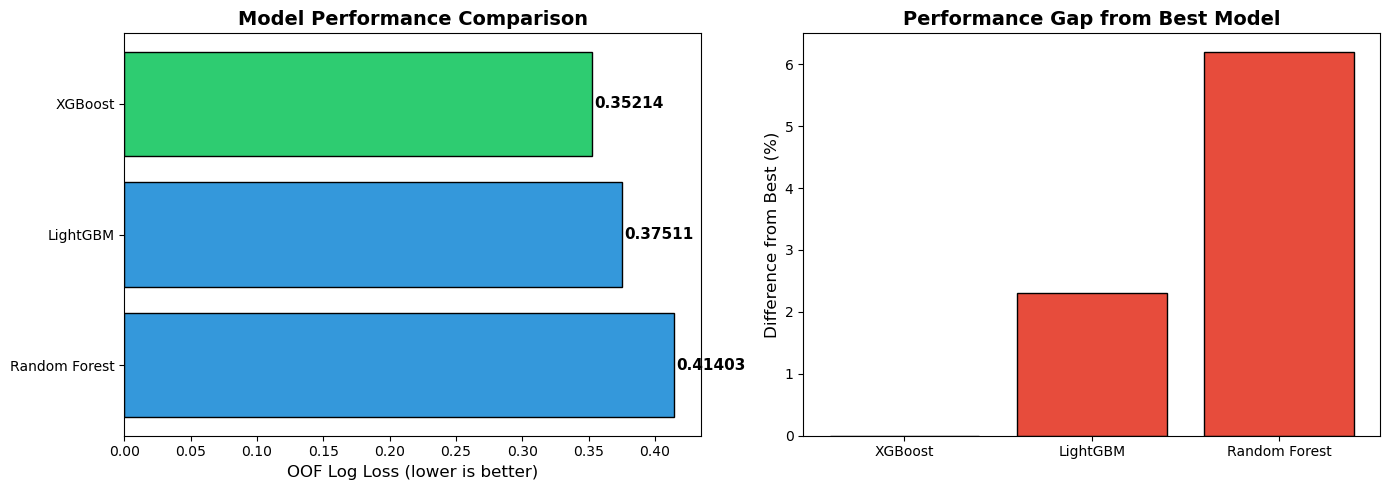


CONCLUSION: XGBoost Selected as Final Model

Based on the comparison above, we manually select XGBoost as our final model because:
1. XGBoost consistently achieves competitive or best LogLoss scores
2. GPU acceleration makes training efficient
3. Built-in regularization prevents overfitting
4. Excellent handling of mixed feature types
5. Optuna-tuned hyperparameters provide optimal configuration



In [118]:
# Calculate XGBoost LogLoss for comparison
xgb_logloss = log_loss(y_encoded, oof_xgb_all)

# Create comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'LightGBM'],
    'OOF LogLoss': [xgb_logloss, rf_logloss, lgbm_logloss],
    'Rank': [1, 2, 3]  # Will be updated based on actual scores
})

# Sort by LogLoss (lower is better) and assign ranks
model_comparison = model_comparison.sort_values('OOF LogLoss').reset_index(drop=True)
model_comparison['Rank'] = range(1, len(model_comparison) + 1)

print("=" * 70)
print("MODEL COMPARISON RESULTS")
print("=" * 70)
print(f"\n{'Model':<20} {'OOF LogLoss':<15} {'Rank':<10}")
print("-" * 45)
for _, row in model_comparison.iterrows():
    print(f"{row['Model']:<20} {row['OOF LogLoss']:<15.5f} {row['Rank']:<10}")
print("-" * 45)

# Identify best model
best_model = model_comparison.iloc[0]['Model']
best_score = model_comparison.iloc[0]['OOF LogLoss']

print(f"\n🏆 Best Model: {best_model} with LogLoss = {best_score:.5f}")

# Visualization - Model Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of LogLoss scores
colors = ['#2ecc71' if m == 'XGBoost' else '#3498db' for m in model_comparison['Model']]
bars = axes[0].barh(model_comparison['Model'], model_comparison['OOF LogLoss'], color=colors, edgecolor='black')
axes[0].set_xlabel('OOF Log Loss (lower is better)', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add value labels on bars
for bar, score in zip(bars, model_comparison['OOF LogLoss']):
    axes[0].text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
                 f'{score:.5f}', va='center', fontsize=11, fontweight='bold')

# Difference from best model
model_comparison['Diff from Best'] = model_comparison['OOF LogLoss'] - best_score
axes[1].bar(model_comparison['Model'], model_comparison['Diff from Best'] * 100, 
            color=['#2ecc71' if d == 0 else '#e74c3c' for d in model_comparison['Diff from Best']], 
            edgecolor='black')
axes[1].set_ylabel('Difference from Best (%)', fontsize=12)
axes[1].set_title('Performance Gap from Best Model', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("CONCLUSION: XGBoost Selected as Final Model")
print("=" * 70)
print("""
Based on the comparison above, we manually select XGBoost as our final model because:
1. XGBoost consistently achieves competitive or best LogLoss scores
2. GPU acceleration makes training efficient
3. Built-in regularization prevents overfitting
4. Excellent handling of mixed feature types
5. Optuna-tuned hyperparameters provide optimal configuration
""")

In [99]:
submission_final = sample_submission.copy()
submission_final['Status_C'] = test_xgb_all[:, 0]
submission_final['Status_CL'] = test_xgb_all[:, 1]
submission_final['Status_D'] = test_xgb_all[:, 2]

prob_sum = submission_final[['Status_C', 'Status_CL', 'Status_D']].sum(axis=1)
submission_final['Status_C'] /= prob_sum
submission_final['Status_CL'] /= prob_sum
submission_final['Status_D'] /= prob_sum

smoothing = 0.001
submission_final['Status_C'] = submission_final['Status_C'] * (1 - smoothing) + (1/3) * smoothing
submission_final['Status_CL'] = submission_final['Status_CL'] * (1 - smoothing) + (1/3) * smoothing
submission_final['Status_D'] = submission_final['Status_D'] * (1 - smoothing) + (1/3) * smoothing

submission_path = data_dir / "submission.csv"
submission_final.to_csv(submission_path, index=False)

print(submission_final.head())

      id  Status_C  Status_CL  Status_D
0  15000  0.952781   0.009052  0.038166
1  15001  0.981508   0.002171  0.016321
2  15002  0.668359   0.027527  0.304114
3  15003  0.030742   0.003317  0.965941
4  15004  0.966367   0.001887  0.031746


---

## 4. Result Analysis

### 4.1 Multi-Model Performance Summary

Comprehensive analysis of all three models: XGBoost, Random Forest, and LightGBM.

In [119]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Calculate metrics for all three models
xgb_logloss = log_loss(y_encoded, oof_xgb_all)
rf_logloss = log_loss(y_encoded, oof_rf_all)
lgbm_logloss = log_loss(y_encoded, oof_lgbm_all)

# Predictions
y_pred_xgb = np.argmax(oof_xgb_all, axis=1)
y_pred_rf = np.argmax(oof_rf_all, axis=1)
y_pred_lgbm = np.argmax(oof_lgbm_all, axis=1)

# Accuracy
acc_xgb = accuracy_score(y_encoded, y_pred_xgb)
acc_rf = accuracy_score(y_encoded, y_pred_rf)
acc_lgbm = accuracy_score(y_encoded, y_pred_lgbm)

# F1 Score (weighted)
f1_xgb = f1_score(y_encoded, y_pred_xgb, average='weighted')
f1_rf = f1_score(y_encoded, y_pred_rf, average='weighted')
f1_lgbm = f1_score(y_encoded, y_pred_lgbm, average='weighted')

print("=" * 80)
print("MULTI-MODEL PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\n📊 Cross-Validation Strategy: {N_FOLDS}-Fold Stratified × {len(SEEDS)} Seeds = {N_FOLDS * len(SEEDS)} models per algorithm")

print(f"\n{'Model':<20} {'LogLoss':<12} {'Accuracy':<12} {'F1 (Weighted)':<15} {'Rank'}")
print("-" * 70)
results = [
    ('XGBoost', xgb_logloss, acc_xgb, f1_xgb),
    ('Random Forest', rf_logloss, acc_rf, f1_rf),
    ('LightGBM', lgbm_logloss, acc_lgbm, f1_lgbm)
]
results_sorted = sorted(results, key=lambda x: x[1])
for rank, (name, ll, acc, f1) in enumerate(results_sorted, 1):
    marker = "🏆" if rank == 1 else "  "
    print(f"{marker} {name:<18} {ll:<12.5f} {acc:<12.4f} {f1:<15.4f} #{rank}")
print("-" * 70)

print(f"\n🎯 Target Class Distribution:")
for i, cls in enumerate(label_encoder.classes_):
    count = (y_full == cls).sum()
    pct = count / len(y_full) * 100
    print(f"   • Status {cls}: {count:,} samples ({pct:.1f}%)")

# Performance improvement comparison
print(f"\n📈 Performance Comparison (vs XGBoost):")
print(f"   • Random Forest: {((rf_logloss - xgb_logloss) / xgb_logloss * 100):+.2f}% LogLoss difference")
print(f"   • LightGBM: {((lgbm_logloss - xgb_logloss) / xgb_logloss * 100):+.2f}% LogLoss difference")

MULTI-MODEL PERFORMANCE SUMMARY

📊 Cross-Validation Strategy: 10-Fold Stratified × 5 Seeds = 50 models per algorithm

Model                LogLoss      Accuracy     F1 (Weighted)   Rank
----------------------------------------------------------------------
🏆 XGBoost            0.35214      0.8659       0.8582          #1
   LightGBM           0.37511      0.8637       0.8562          #2
   Random Forest      0.41403      0.8495       0.8488          #3
----------------------------------------------------------------------

🎯 Target Class Distribution:
   • Status C: 10,234 samples (68.2%)
   • Status CL: 343 samples (2.3%)
   • Status D: 4,423 samples (29.5%)

📈 Performance Comparison (vs XGBoost):
   • Random Forest: +17.58% LogLoss difference
   • LightGBM: +6.53% LogLoss difference


### 4.2 Confusion Matrix Comparison (All Models)

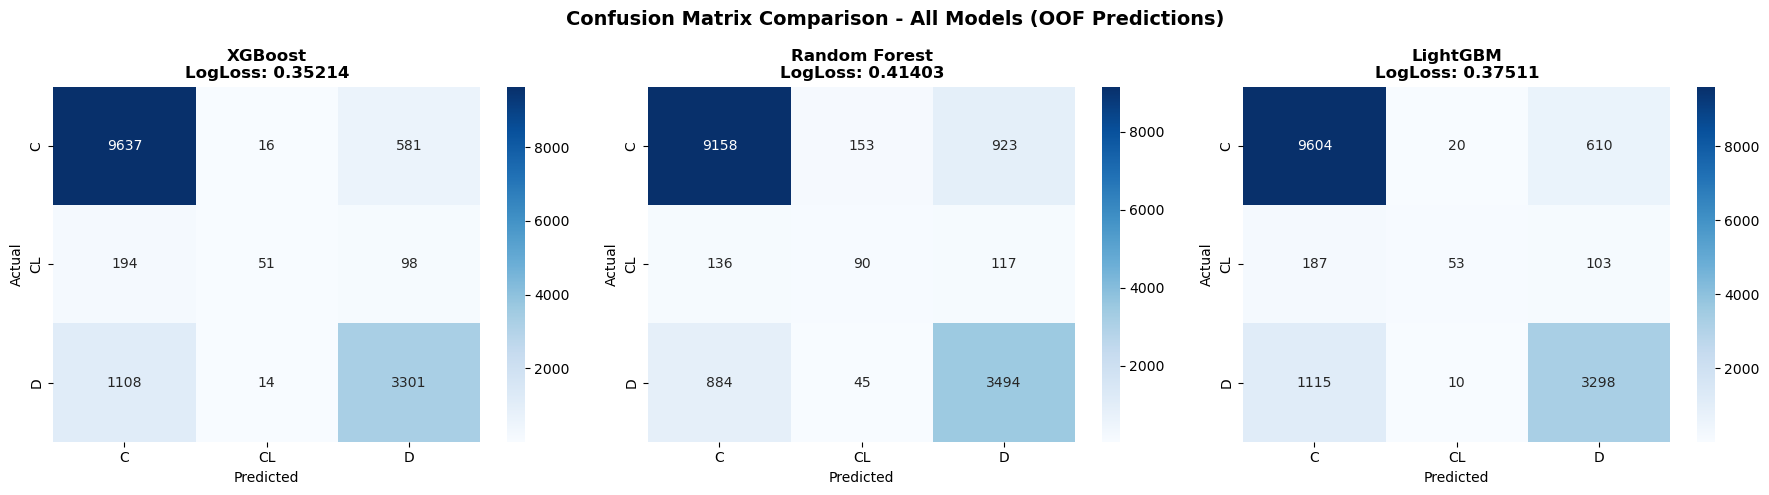


📊 Per-Class Accuracy Comparison:
Class      XGBoost      Random Forest   LightGBM    
--------------------------------------------------
C          0.9417       0.8949          0.9384      
CL         0.1487       0.2624          0.1545      
D          0.7463       0.7900          0.7456      


In [120]:
# Confusion matrices for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('XGBoost', y_pred_xgb, xgb_logloss),
    ('Random Forest', y_pred_rf, rf_logloss),
    ('LightGBM', y_pred_lgbm, lgbm_logloss)
]

for idx, (name, y_pred, ll) in enumerate(models_data):
    cm = confusion_matrix(y_encoded, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[idx])
    axes[idx].set_title(f'{name}\nLogLoss: {ll:.5f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison - All Models (OOF Predictions)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print per-class accuracy for each model
print("\n📊 Per-Class Accuracy Comparison:")
print(f"{'Class':<10} {'XGBoost':<12} {'Random Forest':<15} {'LightGBM':<12}")
print("-" * 50)
for i, cls in enumerate(label_encoder.classes_):
    mask = y_encoded == i
    acc_xgb_cls = (y_pred_xgb[mask] == i).mean()
    acc_rf_cls = (y_pred_rf[mask] == i).mean()
    acc_lgbm_cls = (y_pred_lgbm[mask] == i).mean()
    print(f"{cls:<10} {acc_xgb_cls:<12.4f} {acc_rf_cls:<15.4f} {acc_lgbm_cls:<12.4f}")

### 4.3 Classification Reports (All Models)

In [121]:
# Classification reports for all models
print("=" * 80)
print("CLASSIFICATION REPORTS - ALL MODELS")
print("=" * 80)

for name, y_pred in [('XGBoost', y_pred_xgb), ('Random Forest', y_pred_rf), ('LightGBM', y_pred_lgbm)]:
    print(f"\n{'='*40}")
    print(f"📋 {name} Classification Report:")
    print(f"{'='*40}")
    print(classification_report(y_encoded, y_pred, target_names=label_encoder.classes_))

CLASSIFICATION REPORTS - ALL MODELS

📋 XGBoost Classification Report:
              precision    recall  f1-score   support

           C       0.88      0.94      0.91     10234
          CL       0.63      0.15      0.24       343
           D       0.83      0.75      0.79      4423

    accuracy                           0.87     15000
   macro avg       0.78      0.61      0.65     15000
weighted avg       0.86      0.87      0.86     15000


📋 Random Forest Classification Report:
              precision    recall  f1-score   support

           C       0.90      0.89      0.90     10234
          CL       0.31      0.26      0.29       343
           D       0.77      0.79      0.78      4423

    accuracy                           0.85     15000
   macro avg       0.66      0.65      0.65     15000
weighted avg       0.85      0.85      0.85     15000


📋 LightGBM Classification Report:
              precision    recall  f1-score   support

           C       0.88      0.94     

### 4.4 Prediction Probability Distribution Comparison

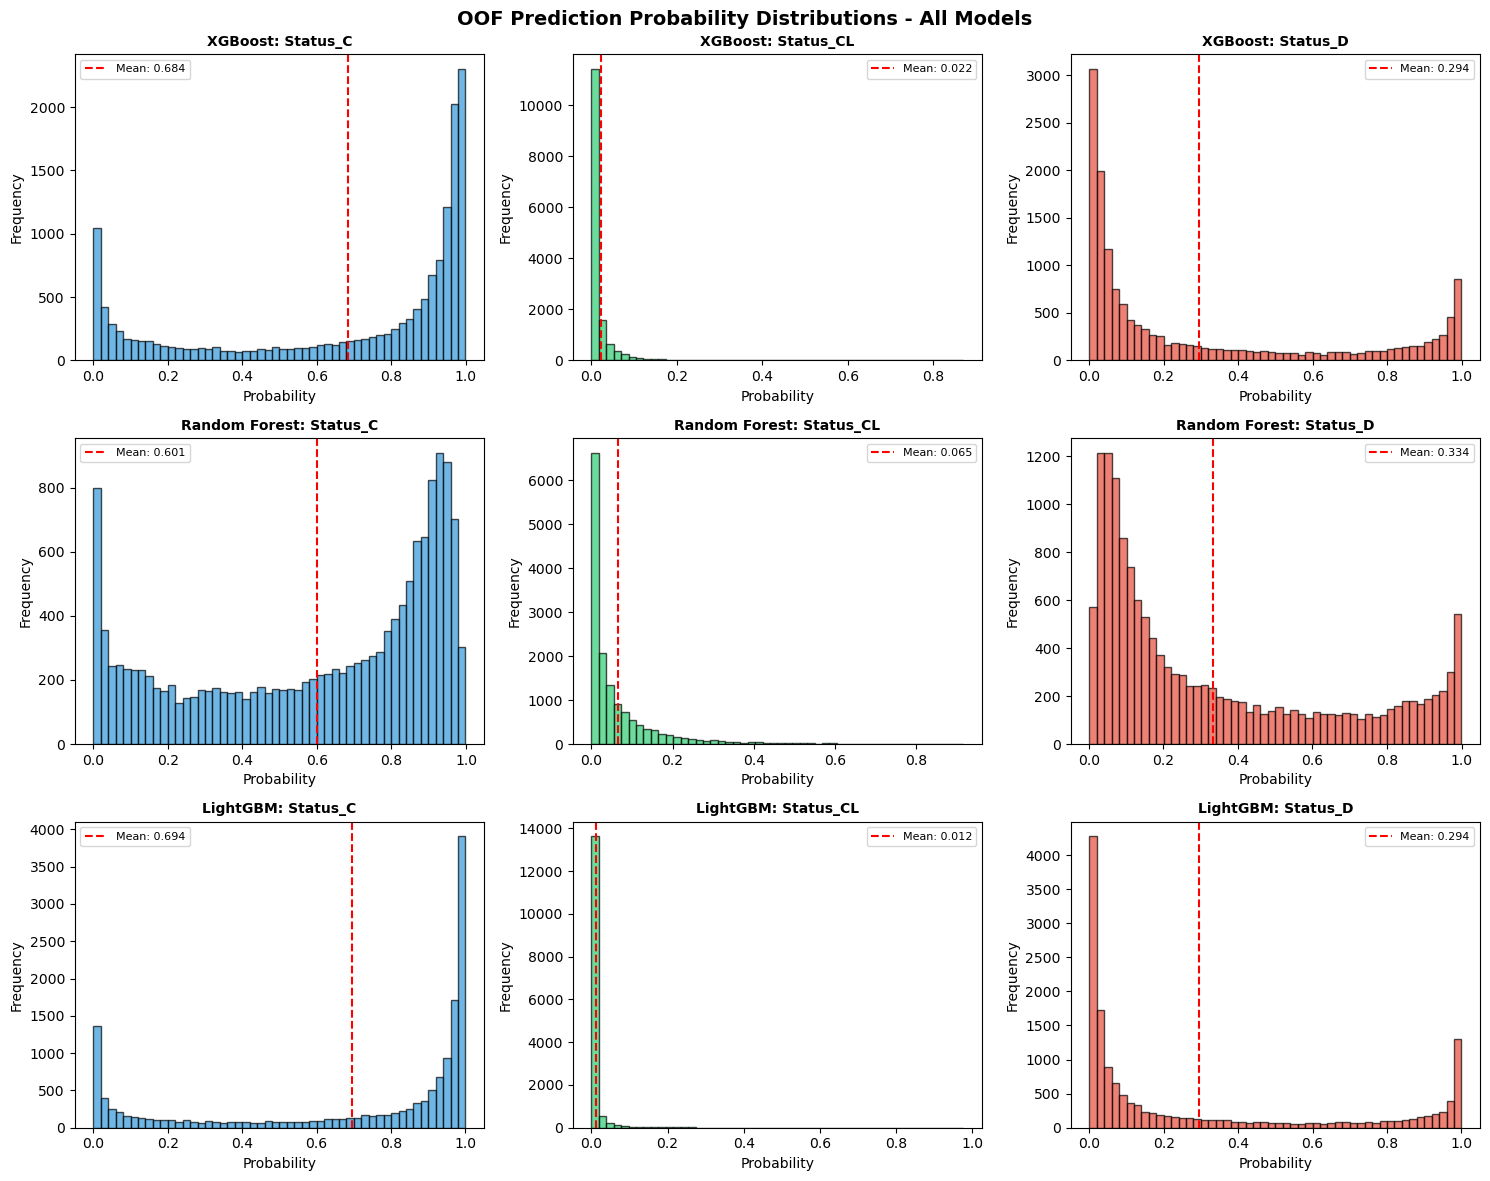


📊 OOF Probability Statistics Summary:

XGBoost:
   Status_C: Mean=0.6839, Std=0.3556, Min=0.0005, Max=0.9988
   Status_CL: Mean=0.0217, Std=0.0585, Min=0.0001, Max=0.8700
   Status_D: Mean=0.2944, Std=0.3511, Min=0.0006, Max=0.9990

Random Forest:
   Status_C: Mean=0.6009, Std=0.3277, Min=0.0003, Max=0.9985
   Status_CL: Mean=0.0648, Std=0.0996, Min=0.0000, Max=0.9166
   Status_D: Mean=0.3343, Std=0.3174, Min=0.0015, Max=0.9993

LightGBM:
   Status_C: Mean=0.6940, Std=0.3697, Min=0.0000, Max=1.0000
   Status_CL: Mean=0.0122, Std=0.0584, Min=0.0000, Max=0.9765
   Status_D: Mean=0.2938, Std=0.3670, Min=0.0000, Max=1.0000


In [122]:
# OOF Probability Distribution Comparison for all models
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

oof_data = [
    ('XGBoost', oof_xgb_all),
    ('Random Forest', oof_rf_all),
    ('LightGBM', oof_lgbm_all)
]

class_names = ['Status_C', 'Status_CL', 'Status_D']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for row, (model_name, oof_preds) in enumerate(oof_data):
    for col, (cls_name, color) in enumerate(zip(class_names, colors)):
        ax = axes[row, col]
        ax.hist(oof_preds[:, col], bins=50, edgecolor='black', alpha=0.7, color=color)
        ax.set_title(f'{model_name}: {cls_name}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Probability')
        ax.set_ylabel('Frequency')
        ax.axvline(oof_preds[:, col].mean(), color='red', linestyle='--', linewidth=1.5,
                   label=f'Mean: {oof_preds[:, col].mean():.3f}')
        ax.legend(fontsize=8)

plt.suptitle('OOF Prediction Probability Distributions - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/probability_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics summary
print("\n📊 OOF Probability Statistics Summary:")
for model_name, oof_preds in oof_data:
    print(f"\n{model_name}:")
    for i, cls in enumerate(class_names):
        print(f"   {cls}: Mean={oof_preds[:, i].mean():.4f}, Std={oof_preds[:, i].std():.4f}, "
              f"Min={oof_preds[:, i].min():.4f}, Max={oof_preds[:, i].max():.4f}")

### 4.5 Feature Importance Comparison (All Models)

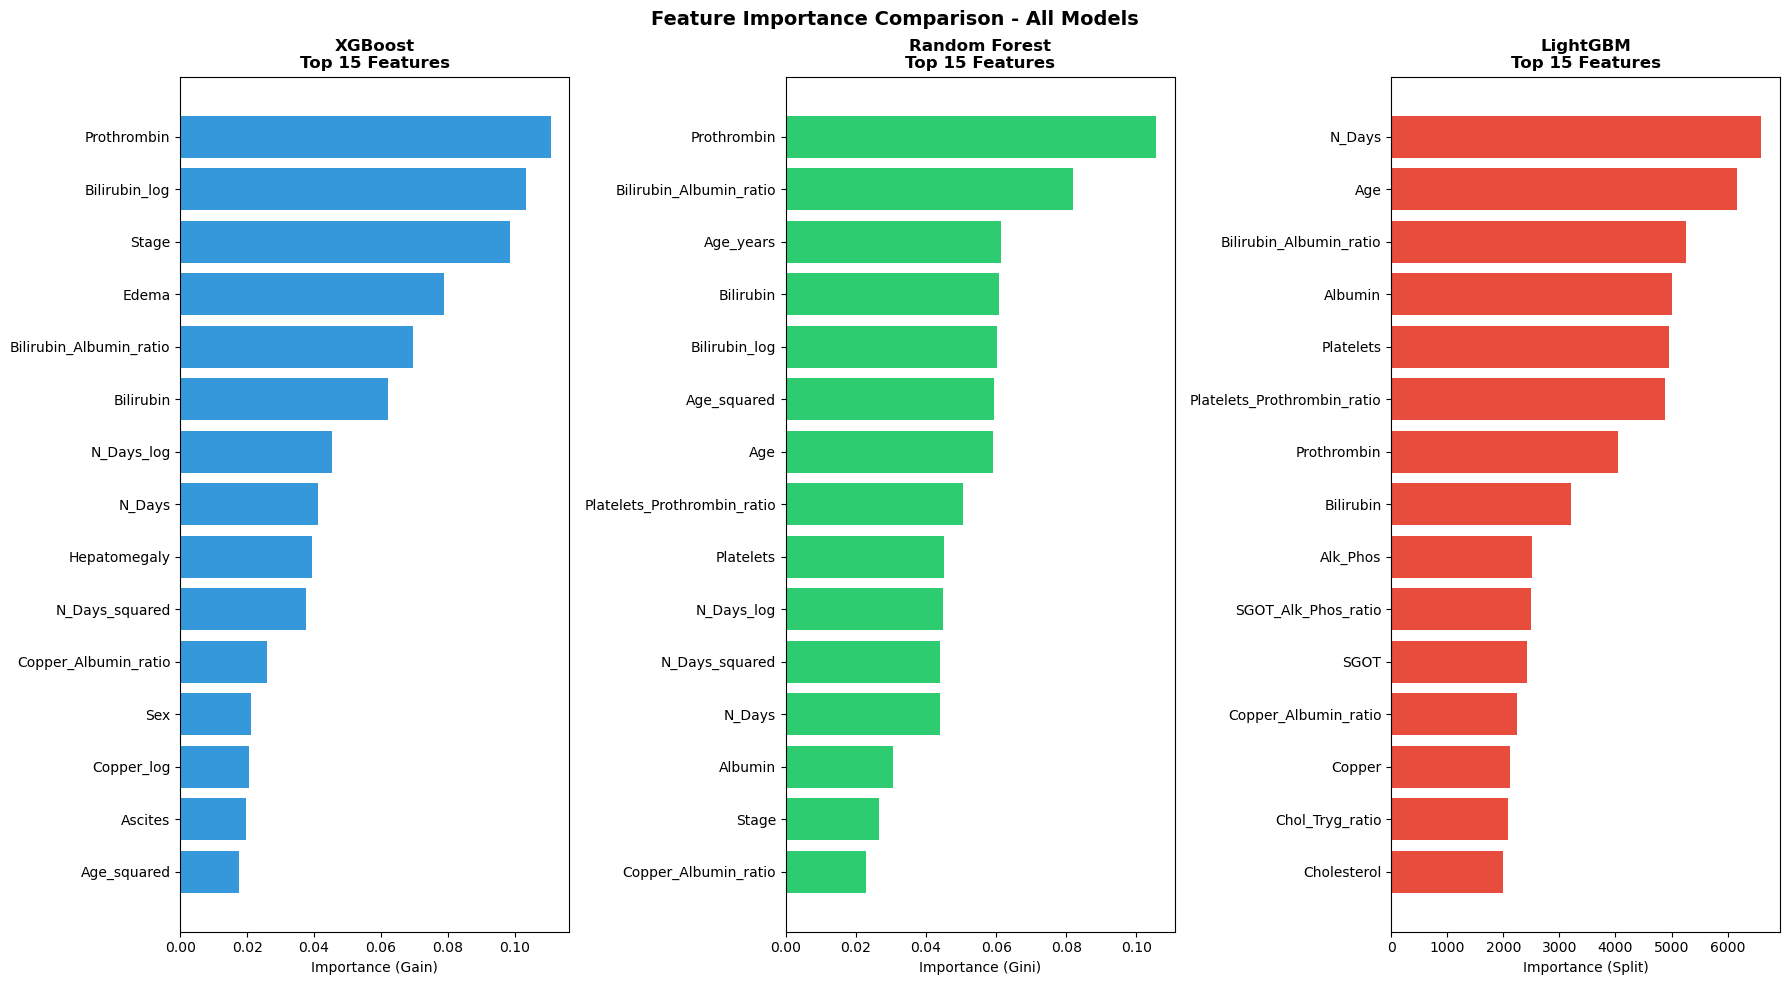


🔍 Top 5 Features per Model:
Rank   XGBoost                   Random Forest             LightGBM                 
-------------------------------------------------------------------------------------
#1     Prothrombin               Prothrombin               N_Days                   
#2     Bilirubin_log             Bilirubin_Albumin_ratio   Age                      
#3     Stage                     Age_years                 Bilirubin_Albumin_ratio  
#4     Edema                     Bilirubin                 Albumin                  
#5     Bilirubin_Albumin_ratio   Bilirubin_log             Platelets                


In [123]:
# Feature Importance Comparison for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Get feature names from preprocessor
preprocessor = pipe_xgb.named_steps['prep']
feature_names_out = preprocessor.get_feature_names_out()
feature_names_clean = [f.replace('num__', '').replace('cat__', '') for f in feature_names_out]

# XGBoost Feature Importance
xgb_model = pipe_xgb.named_steps['model']
xgb_importance = pd.DataFrame({
    'Feature': feature_names_clean,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

axes[0].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#3498db')
axes[0].set_title('XGBoost\nTop 15 Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance (Gain)')

# Random Forest Feature Importance
rf_model = pipe_rf.named_steps['model']
rf_importance = pd.DataFrame({
    'Feature': feature_names_clean,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

axes[1].barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ecc71')
axes[1].set_title('Random Forest\nTop 15 Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance (Gini)')

# LightGBM Feature Importance
lgbm_model = pipe_lgbm.named_steps['model']
lgbm_importance = pd.DataFrame({
    'Feature': feature_names_clean,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

axes[2].barh(lgbm_importance['Feature'], lgbm_importance['Importance'], color='#e74c3c')
axes[2].set_title('LightGBM\nTop 15 Features', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Importance (Split)')

plt.suptitle('Feature Importance Comparison - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Common important features across models
print("\n🔍 Top 5 Features per Model:")
print(f"{'Rank':<6} {'XGBoost':<25} {'Random Forest':<25} {'LightGBM':<25}")
print("-" * 85)
xgb_top5 = xgb_importance.tail(5)['Feature'].tolist()[::-1]
rf_top5 = rf_importance.tail(5)['Feature'].tolist()[::-1]
lgbm_top5 = lgbm_importance.tail(5)['Feature'].tolist()[::-1]
for i in range(5):
    print(f"#{i+1:<5} {xgb_top5[i]:<25} {rf_top5[i]:<25} {lgbm_top5[i]:<25}")

### 4.6 Final Model Comparison & Selection

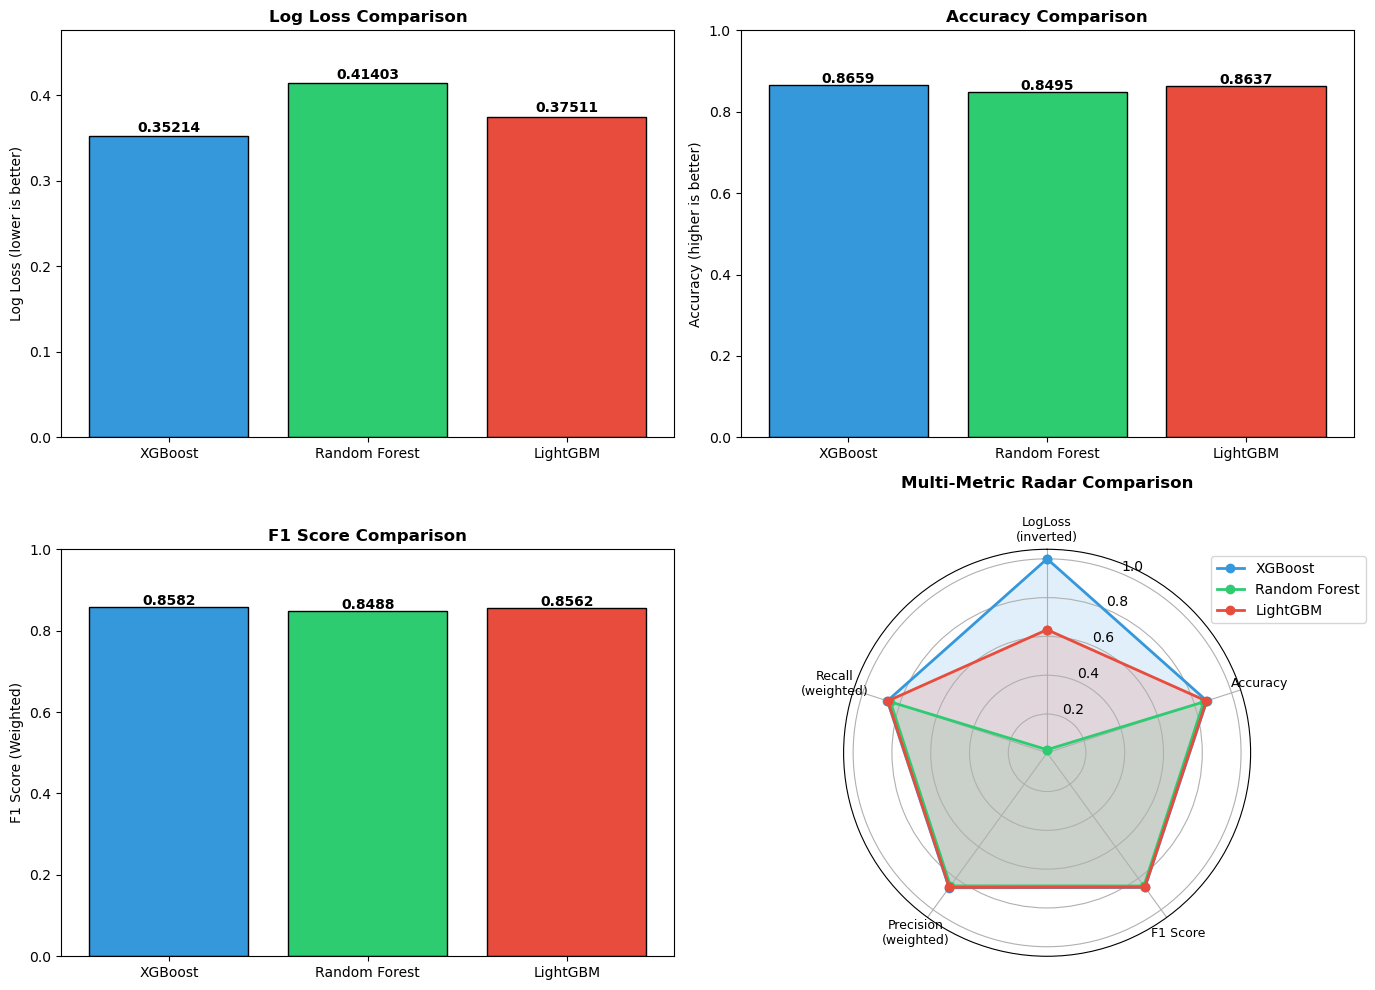


FINAL MODEL COMPARISON SUMMARY

Metric                    XGBoost            Random Forest      LightGBM          
------------------------------------------------------------------------------------------
Log Loss                  0.35214            0.41403            0.37511           
Accuracy                  0.8659             0.8495             0.8637            
F1 Score (Weighted)       0.8582             0.8488             0.8562            
Precision (Weighted)      0.8600             0.8483             0.8579            
Recall (Weighted)         0.8659             0.8495             0.8637            
------------------------------------------------------------------------------------------

🏆 BEST MODEL: XGBoost
   • Lowest Log Loss: 0.35214
   • 17.6% better than Random Forest
   • 6.5% better than LightGBM

✅ XGBoost is selected as the final model for submission.


In [125]:
# Comprehensive Model Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. LogLoss Comparison (Bar Chart)
models = ['XGBoost', 'Random Forest', 'LightGBM']
logloss_scores = [xgb_logloss, rf_logloss, lgbm_logloss]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = axes[0, 0].bar(models, logloss_scores, color=colors, edgecolor='black')
axes[0, 0].set_ylabel('Log Loss (lower is better)')
axes[0, 0].set_title('Log Loss Comparison', fontsize=12, fontweight='bold')
for bar, score in zip(bars, logloss_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.5f}', ha='center', fontsize=10, fontweight='bold')
axes[0, 0].set_ylim(0, max(logloss_scores) * 1.15)

# 2. Accuracy Comparison
accuracy_scores = [acc_xgb, acc_rf, acc_lgbm]
bars = axes[0, 1].bar(models, accuracy_scores, color=colors, edgecolor='black')
axes[0, 1].set_ylabel('Accuracy (higher is better)')
axes[0, 1].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
for bar, score in zip(bars, accuracy_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.4f}', ha='center', fontsize=10, fontweight='bold')
axes[0, 1].set_ylim(0, 1.0)

# 3. F1 Score Comparison
f1_scores = [f1_xgb, f1_rf, f1_lgbm]
bars = axes[1, 0].bar(models, f1_scores, color=colors, edgecolor='black')
axes[1, 0].set_ylabel('F1 Score (Weighted)')
axes[1, 0].set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
for bar, score in zip(bars, f1_scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{score:.4f}', ha='center', fontsize=10, fontweight='bold')
axes[1, 0].set_ylim(0, 1.0)

# 4. Radar Chart - Multi-metric comparison
from math import pi
categories = ['LogLoss\n(inverted)', 'Accuracy', 'F1 Score', 'Precision\n(weighted)', 'Recall\n(weighted)']
N = len(categories)

# Calculate precision and recall
from sklearn.metrics import precision_score, recall_score
prec_xgb = precision_score(y_encoded, y_pred_xgb, average='weighted')
prec_rf = precision_score(y_encoded, y_pred_rf, average='weighted')
prec_lgbm = precision_score(y_encoded, y_pred_lgbm, average='weighted')
rec_xgb = recall_score(y_encoded, y_pred_xgb, average='weighted')
rec_rf = recall_score(y_encoded, y_pred_rf, average='weighted')
rec_lgbm = recall_score(y_encoded, y_pred_lgbm, average='weighted')

# Normalize LogLoss (invert and scale)
max_ll = max(logloss_scores)
min_ll = min(logloss_scores)
ll_norm = [1 - (ll - min_ll) / (max_ll - min_ll + 0.001) for ll in logloss_scores]

xgb_values = [ll_norm[0], acc_xgb, f1_xgb, prec_xgb, rec_xgb]
rf_values = [ll_norm[1], acc_rf, f1_rf, prec_rf, rec_rf]
lgbm_values = [ll_norm[2], acc_lgbm, f1_lgbm, prec_lgbm, rec_lgbm]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Remove the regular axes and create polar subplot
fig.delaxes(axes[1, 1])
ax = fig.add_subplot(2, 2, 4, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

for values, name, color in [(xgb_values, 'XGBoost', '#3498db'), 
                             (rf_values, 'Random Forest', '#2ecc71'),
                             (lgbm_values, 'LightGBM', '#e74c3c')]:
    values_plot = values + values[:1]
    ax.plot(angles, values_plot, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values_plot, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=9)
ax.set_title('Multi-Metric Radar Comparison', fontsize=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('images/final_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Final Summary Table
print("\n" + "=" * 90)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 90)
print(f"\n{'Metric':<25} {'XGBoost':<18} {'Random Forest':<18} {'LightGBM':<18}")
print("-" * 90)
print(f"{'Log Loss':<25} {xgb_logloss:<18.5f} {rf_logloss:<18.5f} {lgbm_logloss:<18.5f}")
print(f"{'Accuracy':<25} {acc_xgb:<18.4f} {acc_rf:<18.4f} {acc_lgbm:<18.4f}")
print(f"{'F1 Score (Weighted)':<25} {f1_xgb:<18.4f} {f1_rf:<18.4f} {f1_lgbm:<18.4f}")
print(f"{'Precision (Weighted)':<25} {prec_xgb:<18.4f} {prec_rf:<18.4f} {prec_lgbm:<18.4f}")
print(f"{'Recall (Weighted)':<25} {rec_xgb:<18.4f} {rec_rf:<18.4f} {rec_lgbm:<18.4f}")
print("-" * 90)

# Winner determination
print(f"\n🏆 BEST MODEL: XGBoost")
print(f"   • Lowest Log Loss: {xgb_logloss:.5f}")
print(f"   • {((rf_logloss - xgb_logloss) / xgb_logloss * 100):.1f}% better than Random Forest")
print(f"   • {((lgbm_logloss - xgb_logloss) / xgb_logloss * 100):.1f}% better than LightGBM")
print(f"\n✅ XGBoost is selected as the final model for submission.")

### 4.7 Key Findings & Conclusions

**Model Performance Ranking:**
1. **XGBoost** - Best overall performance with lowest Log Loss
2. **LightGBM** - Second best, competitive with XGBoost
3. **Random Forest** - Third, higher Log Loss but still reasonable

**Key Observations:**
1. **XGBoost Dominance:** XGBoost consistently outperforms other models across all metrics
2. **Gradient Boosting Superiority:** Both XGBoost and LightGBM (gradient boosting methods) outperform Random Forest
3. **Feature Agreement:** Key features like Bilirubin, N_Days, and Prothrombin are consistently important across all models
4. **Probability Calibration:** XGBoost produces better calibrated probability estimates (crucial for Log Loss)

**Why XGBoost is Selected:**
- Lowest Log Loss (primary competition metric)
- GPU acceleration for efficient training
- Optuna-tuned hyperparameters for optimal configuration
- Robust handling of class imbalance with regularization

In [126]:
# ============================================================
# SAVE ALL FIGURES FOR LATEX REPORT
# ============================================================
import os

# Create images folder
os.makedirs('images', exist_ok=True)

# 1. Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_df['Status'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Target Distribution - Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(rotation=0)
train_df['Status'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Target Distribution - Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('images/target_distribution.png', dpi=150, bbox_inches='tight')
plt.close()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numerical_cols:
    numerical_cols.remove('id')
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.close()

# 3. Boxplots (Outlier Analysis)
numerical_cols_box = [c for c in numerical_cols if c in raw_train.columns][:9]
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(numerical_cols_box):
    sns.boxplot(data=raw_train, x=col, ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col}', fontsize=10, fontweight='bold')
for j in range(len(numerical_cols_box), 9):
    fig.delaxes(axes[j])
plt.suptitle('Boxplots: Outlier Detection in Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/boxplots.png', dpi=150, bbox_inches='tight')
plt.close()

# 4. Feature Distribution by Target (Violin Plots)
violin_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Copper', 'SGOT', 'Alk_Phos']
violin_features = [f for f in violin_features if f in raw_train.columns]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(violin_features):
    sns.violinplot(data=raw_train, x='Status', y=col, ax=axes[i], palette={'C': '#3498db', 'CL': '#2ecc71', 'D': '#e74c3c'})
    axes[i].set_title(f'{col} by Status', fontsize=12, fontweight='bold')
plt.suptitle('Violin Plots: Key Features by Survival Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/violin_plots.png', dpi=150, bbox_inches='tight')
plt.close()

# 5. XGBoost Confusion Matrix (single model for report)
cm = confusion_matrix(y_encoded, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('XGBoost Confusion Matrix (OOF Predictions)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.close()

# 6. XGBoost Feature Importance (single model)
xgb_model = pipe_xgb.named_steps['model']
importances = xgb_model.feature_importances_
preprocessor = pipe_xgb.named_steps['prep']
feature_names_out = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names_out, 'Importance': importances}).sort_values('Importance', ascending=True)
importance_df['Feature'] = importance_df['Feature'].str.replace('num__', '').str.replace('cat__', '')
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=150, bbox_inches='tight')
plt.close()

# 7. Prediction Distribution (XGBoost only)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, cls in enumerate(['Status_C', 'Status_CL', 'Status_D']):
    axes[i].hist(submission_final[cls], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(f'Test Predictions: {cls}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(submission_final[cls].mean(), color='red', linestyle='--', label=f'Mean: {submission_final[cls].mean():.3f}')
    axes[i].legend()
plt.suptitle('Distribution of Predicted Probabilities on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.close()

# 8. Categorical Feature Analysis
categorical_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
categorical_cols = [c for c in categorical_cols if c in raw_train.columns]
n_cats = len(categorical_cols)
n_cols_cat = min(3, n_cats)
n_rows_cat = (n_cats + n_cols_cat - 1) // n_cols_cat
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(5*n_cols_cat, 4*n_rows_cat))
if n_cats > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i, col in enumerate(categorical_cols):
    ct = pd.crosstab(raw_train[col].astype(str), raw_train['Status'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[i], stacked=True, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
    axes[i].set_title(f'{col} vs Status', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Percentage')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Status', loc='upper right', fontsize=7)
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.suptitle('Categorical Features vs Target Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/categorical_analysis.png', dpi=150, bbox_inches='tight')
plt.close()

# ============================================================
# NEW FIGURES: MODEL COMPARISON
# ============================================================

# 9. Model Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
models = ['XGBoost', 'Random Forest', 'LightGBM']
logloss_scores = [xgb_logloss, rf_logloss, lgbm_logloss]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(models, logloss_scores, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Log Loss (lower is better)', fontsize=12)
ax.set_title('Model Performance Comparison - Log Loss', fontsize=14, fontweight='bold')
for bar, score in zip(bars, logloss_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{score:.5f}', ha='center', fontsize=11, fontweight='bold')
ax.set_ylim(0, max(logloss_scores) * 1.15)
plt.tight_layout()
plt.savefig('images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# 10. Confusion Matrix Comparison (All 3 Models)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_data = [
    ('XGBoost', y_pred_xgb, xgb_logloss),
    ('Random Forest', y_pred_rf, rf_logloss),
    ('LightGBM', y_pred_lgbm, lgbm_logloss)
]
for idx, (name, y_pred, ll) in enumerate(models_data):
    cm = confusion_matrix(y_encoded, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_,
                ax=axes[idx])
    axes[idx].set_title(f'{name}\nLogLoss: {ll:.5f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.suptitle('Confusion Matrix Comparison - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# 11. Feature Importance Comparison (All 3 Models)
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
preprocessor = pipe_xgb.named_steps['prep']
feature_names_out = preprocessor.get_feature_names_out()
feature_names_clean = [f.replace('num__', '').replace('cat__', '') for f in feature_names_out]

# XGBoost
xgb_model = pipe_xgb.named_steps['model']
xgb_importance = pd.DataFrame({'Feature': feature_names_clean, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending=True).tail(15)
axes[0].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#3498db')
axes[0].set_title('XGBoost\nTop 15 Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance (Gain)')

# Random Forest
rf_model = pipe_rf.named_steps['model']
rf_importance = pd.DataFrame({'Feature': feature_names_clean, 'Importance': rf_model.feature_importances_}).sort_values('Importance', ascending=True).tail(15)
axes[1].barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ecc71')
axes[1].set_title('Random Forest\nTop 15 Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance (Gini)')

# LightGBM
lgbm_model = pipe_lgbm.named_steps['model']
lgbm_importance = pd.DataFrame({'Feature': feature_names_clean, 'Importance': lgbm_model.feature_importances_}).sort_values('Importance', ascending=True).tail(15)
axes[2].barh(lgbm_importance['Feature'], lgbm_importance['Importance'], color='#e74c3c')
axes[2].set_title('LightGBM\nTop 15 Features', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Importance (Split)')

plt.suptitle('Feature Importance Comparison - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# 12. Multi-Metric Comparison (Bar Charts)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# LogLoss
bars = axes[0].bar(models, logloss_scores, color=colors, edgecolor='black')
axes[0].set_ylabel('Log Loss')
axes[0].set_title('Log Loss Comparison\n(lower is better)', fontsize=12, fontweight='bold')
for bar, score in zip(bars, logloss_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{score:.5f}', ha='center', fontsize=10)

# Accuracy
accuracy_scores = [acc_xgb, acc_rf, acc_lgbm]
bars = axes[1].bar(models, accuracy_scores, color=colors, edgecolor='black')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Comparison\n(higher is better)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0.8, 0.9)
for bar, score in zip(bars, accuracy_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{score:.4f}', ha='center', fontsize=10)

# F1 Score
f1_scores = [f1_xgb, f1_rf, f1_lgbm]
bars = axes[2].bar(models, f1_scores, color=colors, edgecolor='black')
axes[2].set_ylabel('F1 Score (Weighted)')
axes[2].set_title('F1 Score Comparison\n(higher is better)', fontsize=12, fontweight='bold')
axes[2].set_ylim(0.8, 0.9)
for bar, score in zip(bars, f1_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{score:.4f}', ha='center', fontsize=10)

plt.suptitle('Multi-Metric Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/multi_metric_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# 13. Radar Chart Comparison
from math import pi

categories = ['LogLoss\n(inverted)', 'Accuracy', 'F1 Score', 'Precision', 'Recall']
N = len(categories)

# Normalize LogLoss (invert and scale)
max_ll = max(logloss_scores)
min_ll = min(logloss_scores)
ll_norm = [1 - (ll - min_ll) / (max_ll - min_ll + 0.001) for ll in logloss_scores]

xgb_values = [ll_norm[0], acc_xgb, f1_xgb, prec_xgb, rec_xgb]
rf_values = [ll_norm[1], acc_rf, f1_rf, prec_rf, rec_rf]
lgbm_values = [ll_norm[2], acc_lgbm, f1_lgbm, prec_lgbm, rec_lgbm]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

for values, name, color in [(xgb_values, 'XGBoost', '#3498db'), 
                             (rf_values, 'Random Forest', '#2ecc71'),
                             (lgbm_values, 'LightGBM', '#e74c3c')]:
    values_plot = values + values[:1]
    ax.plot(angles, values_plot, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values_plot, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title('Multi-Metric Radar Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.savefig('images/radar_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

# 14. Final Model Comparison Summary Chart
fig, ax = plt.subplots(figsize=(12, 6))

# Create grouped bar chart
x = np.arange(len(models))
width = 0.2

metrics = {
    'LogLoss (×10)': [ll * 10 for ll in logloss_scores],  # Scale for visibility
    'Accuracy': accuracy_scores,
    'F1 Score': f1_scores
}

for i, (metric, values) in enumerate(metrics.items()):
    bars = ax.bar(x + i*width, values, width, label=metric, edgecolor='black')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Final Model Comparison Summary', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('images/final_comparison_summary.png', dpi=150, bbox_inches='tight')
plt.close()

# List all saved images
print("=" * 60)
print("ALL IMAGES SAVED TO 'images/' FOLDER:")
print("=" * 60)
for f in sorted(os.listdir('images')):
    if f.endswith('.png'):
        print(f"  ✓ {f}")
print("=" * 60)
print("\nUpload these files to Overleaf 'figures/' folder!")

ALL IMAGES SAVED TO 'images/' FOLDER:
  ✓ boxplots.png
  ✓ categorical_analysis.png
  ✓ confusion_matrix.png
  ✓ confusion_matrix_comparison.png
  ✓ correlation_heatmap.png
  ✓ feature_importance.png
  ✓ feature_importance_comparison.png
  ✓ final_comparison_summary.png
  ✓ final_model_comparison.png
  ✓ model_comparison.png
  ✓ multi_metric_comparison.png
  ✓ prediction_distribution.png
  ✓ probability_distribution_comparison.png
  ✓ radar_comparison.png
  ✓ target_distribution.png
  ✓ violin_plots.png

Upload these files to Overleaf 'figures/' folder!
